In [1]:
# ================================
# CELL 1: Imports & Configuration
# ================================

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

import warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.rcParams["figure.figsize"] = (10, 5)

# -------------------------------
# Define Asset Universe
# -------------------------------
stocks = ["AAPL", "MSFT", "JPM", "XOM", "AMZN"]
market_index = "^GSPC"
vix_index = "^VIX"

print("Assets loaded:")
print(stocks)


Assets loaded:
['AAPL', 'MSFT', 'JPM', 'XOM', 'AMZN']


In [2]:
# ==================================
# CELL 2: Download Market Data
# ==================================

start_date = "2015-01-01"
end_date = None  # None = today

# Dictionary to store stock data
stock_data = {}

for ticker in stocks:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df.dropna(inplace=True)
    stock_data[ticker] = df

# Download market index and VIX
market_data = yf.download(market_index, start=start_date, end=end_date, progress=False)
vix_data = yf.download(vix_index, start=start_date, end=end_date, progress=False)

market_data.dropna(inplace=True)
vix_data.dropna(inplace=True)

print("Downloaded data for:")
print("Stocks:", list(stock_data.keys()))
print("Market index:", market_index)
print("VIX index:", vix_index)


Downloaded data for:
Stocks: ['AAPL', 'MSFT', 'JPM', 'XOM', 'AMZN']
Market index: ^GSPC
VIX index: ^VIX


In [6]:
# ==========================================
# CELL 3 (ROBUST): Returns & Alignment
# ==========================================

def flatten_columns(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df

# Flatten columns for market and VIX
market_data = flatten_columns(market_data)
vix_data = flatten_columns(vix_data)

# Compute market returns
market_data["Market_Return"] = np.log(
    market_data["Close"] / market_data["Close"].shift(1)
)

# Compute VIX daily percentage change
vix_data["VIX_Change"] = vix_data["Close"].pct_change()

processed_data = {}

for ticker, df in stock_data.items():
    temp = flatten_columns(df.copy())
    
    # Stock log returns
    temp["Return"] = np.log(temp["Close"] / temp["Close"].shift(1))
    
    # Align with market and VIX
    temp = temp.join(
        market_data[["Market_Return"]], how="inner"
    )
    temp = temp.join(
        vix_data[["VIX_Change"]], how="inner"
    )
    
    temp.dropna(inplace=True)
    processed_data[ticker] = temp

# Inspect one stock
sample_ticker = stocks[0]
processed_data[sample_ticker].head()


Price,Close,High,Low,Open,Volume,Return,Market_Return,VIX_Change
Date,,,,,,,,
2015-01-05,23.554741,24.086801,23.368521,24.006992,257142000,-0.028576,-0.018447,0.119730
2015-01-06,23.556953,23.816332,23.195595,23.619027,263188400,0.000094,-0.008933,0.060241
2015-01-07,23.887280,23.987040,23.654503,23.765348,160423600,0.013925,0.011563,-0.085701
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000,0.037703,0.017730,-0.119109
2015-01-09,24.831684,25.106581,24.432638,24.978000,214798000,0.001072,-0.008439,0.031746


In [7]:
# ==========================================
# CELL 4: Price-Based Feature Engineering
# ==========================================

price_feature_data = {}

for ticker, df in processed_data.items():
    temp = df.copy()
    
    # Lagged returns
    temp["Return_Lag_1"] = temp["Return"].shift(1)
    temp["Return_Lag_3"] = temp["Return"].rolling(3).mean()
    temp["Return_Lag_5"] = temp["Return"].rolling(5).mean()
    
    # Moving averages
    temp["MA_5"] = temp["Close"].rolling(5).mean()
    temp["MA_20"] = temp["Close"].rolling(20).mean()
    
    # Momentum (difference of moving averages)
    temp["Momentum"] = temp["MA_5"] - temp["MA_20"]
    
    temp.dropna(inplace=True)
    price_feature_data[ticker] = temp

# Inspect one stock
price_feature_data[sample_ticker].head()


Price,Close,High,Low,Open,Volume,Return,Market_Return,VIX_Change,Return_Lag_1,Return_Lag_3,Return_Lag_5,MA_5,MA_20,Momentum
Date,,,,,,,,,,,,,,
2015-02-02,26.299284,26.418998,25.733971,26.170704,250956400,0.012469,0.012879,-0.073438,-0.014742,0.009462,0.009547,25.678103,24.631386,1.046717
2015-02-03,26.303715,26.401258,26.073155,26.270461,207662800,0.000168,0.014336,-0.108080,0.012469,-0.000702,0.016709,26.099760,24.768835,1.330925
2015-02-04,26.505453,26.716061,26.228339,26.270461,280598800,0.007640,-0.004165,0.057703,0.000168,0.006759,0.007239,26.288198,24.916260,1.371938
2015-02-05,26.694639,26.759184,26.541068,26.712443,168984800,0.007112,0.010239,-0.080742,0.007640,0.004974,0.002530,26.355298,25.056628,1.298670
2015-02-06,26.469841,26.763629,26.363008,26.712438,174826400,-0.008457,-0.003424,0.026113,0.007112,0.002099,0.003787,26.454586,25.139866,1.314721


In [8]:
# ==========================================
# CELL 5: Volume-Based Feature Engineering
# ==========================================

volume_feature_data = {}

for ticker, df in price_feature_data.items():
    temp = df.copy()
    
    # Volume change
    temp["Volume_Change"] = temp["Volume"].pct_change()
    
    # Rolling average volume
    temp["Avg_Volume_5"] = temp["Volume"].rolling(5).mean()
    temp["Avg_Volume_20"] = temp["Volume"].rolling(20).mean()
    
    # Volume surprise (liquidity shock)
    temp["Volume_Surprise"] = temp["Volume"] / temp["Avg_Volume_20"]
    
    # Dollar volume (liquidity scale)
    temp["Dollar_Volume"] = temp["Close"] * temp["Volume"]
    
    temp.dropna(inplace=True)
    volume_feature_data[ticker] = temp

# Inspect one stock
volume_feature_data[sample_ticker].head()


Price,Close,High,Low,Open,Volume,Return,Market_Return,VIX_Change,Return_Lag_1,Return_Lag_3,Return_Lag_5,MA_5,MA_20,Momentum,Volume_Change,Avg_Volume_5,Avg_Volume_20,Volume_Surprise,Dollar_Volume
Date,,,,,,,,,,,,,,,,,,,
2015-03-02,28.731123,28.995978,28.555297,28.766734,192386800,0.004892,0.006106,-0.022489,-0.015142,0.000775,-0.005968,28.886027,27.942093,0.943935,-0.224432,276271040.0,236926380.0,0.812011,5.527489e+09
2015-03-03,28.791224,28.826835,28.508563,28.702198,151265200,0.002090,-0.004549,0.062883,0.004892,-0.002720,-0.004298,28.760947,28.066690,0.694258,-0.213744,251141600.0,231941820.0,0.652169,4.355110e+09
2015-03-04,28.608711,28.835730,28.559750,28.733351,126665200,-0.006359,-0.004398,0.026696,0.002090,0.000207,-0.000389,28.749818,28.181939,0.567879,-0.162628,216705280.0,227891940.0,0.555813,3.623728e+09
2015-03-05,28.134644,28.655449,27.989975,28.617613,226068400,-0.016710,0.001195,-0.013352,-0.006359,-0.006993,-0.006246,28.571322,28.263399,0.307923,0.784771,188888960.0,225165420.0,1.004010,6.360354e+09
2015-03-06,28.176935,28.793444,28.101263,28.577554,291368400,0.001502,-0.014275,0.082621,-0.016710,-0.007189,-0.002917,28.488527,28.337514,0.151014,0.288851,197550800.0,231284600.0,1.259783,8.209869e+09


In [10]:
# ==========================================
# CELL 6: Volatility & Range Features
# ==========================================

vol_feature_data = {}

for ticker, df in volume_feature_data.items():
    temp = df.copy()
    
    # Intraday price range
    temp["Daily_Range"] = (temp["High"] - temp["Low"]) / temp["Close"]
    
    # Rolling realized volatility (returns-based)
    temp["RV_5"] = temp["Return"].rolling(5).std()
    temp["RV_20"] = temp["Return"].rolling(20).std()
    
    # True range approximation
    temp["True_Range"] = (temp["High"] - temp["Low"])
    temp["ATR_5"] = temp["True_Range"].rolling(5).mean()
    
    temp.dropna(inplace=True)
    vol_feature_data[ticker] = temp

# Inspect one stock
vol_feature_data[sample_ticker].head()


Price,Close,High,Low,Open,Volume,Return,Market_Return,VIX_Change,Return_Lag_1,Return_Lag_3,...,Volume_Change,Avg_Volume_5,Avg_Volume_20,Volume_Surprise,Dollar_Volume,Daily_Range,RV_5,RV_20,True_Range,ATR_5
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-27,27.431334,27.754054,27.355662,27.725121,158184800,-0.008001,0.002366,-0.046203,0.006946,-0.009176,...,-0.168724,167461040.0,209890360.0,0.753654,4.339220e+09,0.014523,0.014548,0.012776,0.398393,0.459377
2015-03-30,28.125746,28.132423,27.598262,27.609391,188398800,0.024999,0.012162,-0.037160,-0.008001,0.007982,...,0.191004,174973040.0,209690960.0,0.898459,5.298857e+09,0.018992,0.019014,0.014078,0.534160,0.507006
2015-03-31,27.693964,28.152451,27.678384,28.063424,168362400,-0.015471,-0.008835,0.053756,0.024999,0.000509,...,-0.106351,182371680.0,210545820.0,0.799647,4.662622e+09,0.017118,0.020079,0.014414,0.474066,0.535940
2015-04-01,27.653898,27.847532,27.397946,27.780761,162485600,-0.001448,-0.003973,-0.011772,-0.015471,0.002694,...,-0.034906,173544640.0,212336840.0,0.765226,4.493360e+09,0.016258,0.015563,0.014377,0.449585,0.472731
2015-04-02,27.892050,27.945465,27.640550,27.827505,128880400,0.008575,0.003523,-0.029120,-0.001448,-0.002781,...,-0.206820,161262400.0,207477440.0,0.621178,3.594739e+09,0.010932,0.015724,0.014096,0.304915,0.432224


In [11]:
# ==========================================
# CELL 7: Final Feature Set & Target
# ==========================================

final_data = {}

for ticker, df in vol_feature_data.items():
    temp = df.copy()
    
    # Target: next-day return
    temp["Target"] = temp["Return"].shift(-1)
    
    # Optional: classification target (up=1, down=0)
    temp["Target_Dir"] = (temp["Target"] > 0).astype(int)
    
    # Drop rows with NaN target
    temp.dropna(inplace=True)
    
    # Drop columns that are not features
    features = [
        "Return_Lag_1", "Return_Lag_3", "Return_Lag_5",
        "MA_5", "MA_20", "Momentum",
        "Volume_Change", "Avg_Volume_5", "Avg_Volume_20", "Volume_Surprise", "Dollar_Volume",
        "Daily_Range", "RV_5", "RV_20", "ATR_5",
        "Market_Return", "VIX_Change"
    ]
    
    X = temp[features]
    y = temp["Target"]
    y_dir = temp["Target_Dir"]
    
    final_data[ticker] = {"X": X, "y": y, "y_dir": y_dir}

# Inspect feature and target for one stock
sample = final_data[sample_ticker]
print("Features shape:", sample["X"].shape)
print("Target shape:", sample["y"].shape)
sample["X"].head()


Features shape: (2718, 17)
Target shape: (2718,)


Price,Return_Lag_1,Return_Lag_3,Return_Lag_5,MA_5,MA_20,Momentum,Volume_Change,Avg_Volume_5,Avg_Volume_20,Volume_Surprise,Dollar_Volume,Daily_Range,RV_5,RV_20,ATR_5,Market_Return,VIX_Change
Date,,,,,,,,,,,,,,,,,
2015-03-27,0.006946,-0.009176,-0.004255,27.810590,28.049626,-0.239036,-0.168724,167461040.0,209890360.0,0.753654,4.339220e+09,0.014523,0.014548,0.012776,0.459377,0.002366,-0.046203
2015-03-30,-0.008001,0.007982,-0.001325,27.773199,28.019357,-0.246157,0.191004,174973040.0,209690960.0,0.898459,5.298857e+09,0.018992,0.019014,0.014078,0.507006,0.012162,-0.037160
2015-03-31,0.024999,0.000509,-0.003600,27.672599,27.964494,-0.291895,-0.106351,182371680.0,210545820.0,0.799647,4.662622e+09,0.017118,0.020079,0.014414,0.535940,-0.008835,0.053756
2015-04-01,-0.015471,0.002694,0.001405,27.711324,27.916753,-0.205429,-0.034906,173544640.0,212336840.0,0.765226,4.493360e+09,0.016258,0.015563,0.014377,0.472731,-0.003973,-0.011772
2015-04-02,-0.001448,-0.002781,0.001731,27.759398,27.904624,-0.145225,-0.206820,161262400.0,207477440.0,0.621178,3.594739e+09,0.010932,0.015724,0.014096,0.432224,0.003523,-0.029120


In [14]:
# ==========================================
# CELL 8: Volume-Enhanced Features
# ==========================================

volume_enhanced_data = {}

for ticker, df in final_data.items():
    temp = df["X"].copy()  # start with current features
    
    # Volume-weighted return and momentum
    temp["Return_x_Volume"] = temp["Return_Lag_1"] * df["X"]["Volume_Surprise"]
    temp["Momentum_x_Volume"] = temp["Momentum"] * df["X"]["Volume_Surprise"]
    
    # Normalized Dollar Volume (rolling 20 days)
    temp["Dollar_Volume_Norm"] = df["X"]["Dollar_Volume"] / df["X"]["Dollar_Volume"].rolling(20).mean()
    
    # High-volume day flag (1 if Volume_Surprise > 1.2)
    temp["High_Volume_Day"] = (df["X"]["Volume_Surprise"] > 1.2).astype(int)
    
    # Drop any NaNs created by rolling mean
    temp.dropna(inplace=True)
    
    # Keep targets aligned
    y = df["y"].loc[temp.index]
    y_dir = df["y_dir"].loc[temp.index]
    
    volume_enhanced_data[ticker] = {"X": temp, "y": y, "y_dir": y_dir}

# Inspect one stock
sample = volume_enhanced_data[sample_ticker]
sample["X"].head()


Price,Return_Lag_1,Return_Lag_3,Return_Lag_5,MA_5,MA_20,Momentum,Volume_Change,Avg_Volume_5,Avg_Volume_20,Volume_Surprise,...,Daily_Range,RV_5,RV_20,ATR_5,Market_Return,VIX_Change,Return_x_Volume,Momentum_x_Volume,Dollar_Volume_Norm,High_Volume_Day
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-24,0.008131,0.008736,0.008675,28.625629,28.156568,0.469060,-0.027201,165952560.0,152482460.0,1.168027,...,0.010746,0.010376,0.011106,0.476738,0.002250,-0.015224,0.009497,0.547875,1.202562,0
2015-04-27,0.004693,0.010284,0.007763,28.850421,28.261175,0.589246,1.177479,205872480.0,163964060.0,2.365255,...,0.014927,0.008950,0.011349,0.433560,-0.004150,0.067535,0.011100,1.393717,2.462337,1
2015-04-28,0.018028,0.002280,0.005671,29.012895,28.307802,0.705092,0.226600,275063600.0,178328920.0,2.667520,...,0.038067,0.013074,0.010981,0.586686,0.002765,-0.054116,0.048090,1.880848,2.723120,1
2015-04-29,-0.015881,-0.004223,0.000031,29.013784,28.354653,0.659132,-0.467003,295648880.0,182588020.0,1.388615,...,0.025575,0.014873,0.010929,0.619625,-0.003747,0.078969,-0.022053,0.915280,1.394405,1
2015-04-30,-0.014815,-0.019400,-0.007096,28.812583,28.364668,0.447915,0.312518,325588480.0,191102820.0,1.741375,...,0.032441,0.018190,0.012725,0.698859,-0.010181,0.086632,-0.025799,0.779987,1.702437,1


In [15]:
# ==========================================
# CELL 9: Final Model-Ready Feature Set
# ==========================================

final_model_data = {}

for ticker, df in volume_enhanced_data.items():
    X = df["X"].copy()
    y = df["y"].copy()
    y_dir = df["y_dir"].copy()
    
    # Optional: Drop original 'Price' if present, keep numeric features only
    if "Price" in X.columns:
        X.drop(columns=["Price"], inplace=True)
    
    final_model_data[ticker] = {"X": X, "y": y, "y_dir": y_dir}

# Inspect one stock
sample = final_model_data[sample_ticker]
print("Features shape:", sample["X"].shape)
print("Target shape:", sample["y"].shape)
sample["X"].head()


Features shape: (2699, 21)
Target shape: (2699,)


Price,Return_Lag_1,Return_Lag_3,Return_Lag_5,MA_5,MA_20,Momentum,Volume_Change,Avg_Volume_5,Avg_Volume_20,Volume_Surprise,...,Daily_Range,RV_5,RV_20,ATR_5,Market_Return,VIX_Change,Return_x_Volume,Momentum_x_Volume,Dollar_Volume_Norm,High_Volume_Day
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-24,0.008131,0.008736,0.008675,28.625629,28.156568,0.469060,-0.027201,165952560.0,152482460.0,1.168027,...,0.010746,0.010376,0.011106,0.476738,0.002250,-0.015224,0.009497,0.547875,1.202562,0
2015-04-27,0.004693,0.010284,0.007763,28.850421,28.261175,0.589246,1.177479,205872480.0,163964060.0,2.365255,...,0.014927,0.008950,0.011349,0.433560,-0.004150,0.067535,0.011100,1.393717,2.462337,1
2015-04-28,0.018028,0.002280,0.005671,29.012895,28.307802,0.705092,0.226600,275063600.0,178328920.0,2.667520,...,0.038067,0.013074,0.010981,0.586686,0.002765,-0.054116,0.048090,1.880848,2.723120,1
2015-04-29,-0.015881,-0.004223,0.000031,29.013784,28.354653,0.659132,-0.467003,295648880.0,182588020.0,1.388615,...,0.025575,0.014873,0.010929,0.619625,-0.003747,0.078969,-0.022053,0.915280,1.394405,1
2015-04-30,-0.014815,-0.019400,-0.007096,28.812583,28.364668,0.447915,0.312518,325588480.0,191102820.0,1.741375,...,0.032441,0.018190,0.012725,0.698859,-0.010181,0.086632,-0.025799,0.779987,1.702437,1


In [16]:
# ==========================================
# CELL 10: Linear Regression Baseline (Enhanced Features)
# ==========================================

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

baseline_enhanced_results = {}

for ticker, data in final_model_data.items():
    X = data["X"]
    y = data["y"]
    
    # Train-test split: last 20% for testing
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    baseline_enhanced_results[ticker] = mse

# Display baseline performance with enhanced features
baseline_enhanced_results


{'AAPL': 0.00029720776191038126,
 'MSFT': 0.0001943228890240298,
 'JPM': 0.0002547940377128974,
 'XOM': 0.00018381886472917505,
 'AMZN': 0.0003814148134861673}

In [17]:
# ==========================================
# CELL 11: Ridge, Lasso, ElasticNet
# ==========================================

from sklearn.linear_model import Ridge, Lasso, ElasticNet

regularized_results = {}

for ticker, data in final_model_data.items():
    X = data["X"]
    y = data["y"]
    
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_ridge_pred = ridge.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_ridge_pred)
    
    # Lasso Regression
    lasso = Lasso(alpha=0.001)  # small alpha to prevent underfitting
    lasso.fit(X_train, y_train)
    y_lasso_pred = lasso.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_lasso_pred)
    
    # ElasticNet
    enet = ElasticNet(alpha=0.001, l1_ratio=0.5)
    enet.fit(X_train, y_train)
    y_enet_pred = enet.predict(X_test)
    mse_enet = mean_squared_error(y_test, y_enet_pred)
    
    regularized_results[ticker] = {
        "Ridge_MSE": mse_ridge,
        "Lasso_MSE": mse_lasso,
        "ElasticNet_MSE": mse_enet
    }

# Display results
regularized_results


{'AAPL': {'Ridge_MSE': 0.00029876622706678335,
  'Lasso_MSE': 0.0002888874070361619,
  'ElasticNet_MSE': 0.00028889084405145577},
 'MSFT': {'Ridge_MSE': 0.0001933133702211187,
  'Lasso_MSE': 0.00018799651822119323,
  'ElasticNet_MSE': 0.00018833899291129528},
 'JPM': {'Ridge_MSE': 0.00024195034046583066,
  'Lasso_MSE': 0.00023221182238019735,
  'ElasticNet_MSE': 0.00023291511865619876},
 'XOM': {'Ridge_MSE': 0.0001856685930390565,
  'Lasso_MSE': 0.00018711842614548802,
  'ElasticNet_MSE': 0.00018726196552653536},
 'AMZN': {'Ridge_MSE': 0.00037943270208173256,
  'Lasso_MSE': 0.0003751701274175923,
  'ElasticNet_MSE': 0.00037524931775028504}}

In [18]:
# ==========================================
# CELL 12: Tree-Based Models
# ==========================================

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb

tree_results = {}

for ticker, data in final_model_data.items():
    X = data["X"]
    y = data["y"]
    
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_rf_pred = rf.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_rf_pred)
    
    # Gradient Boosting
    gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    gb.fit(X_train, y_train)
    y_gb_pred = gb.predict(X_test)
    mse_gb = mean_squared_error(y_test, y_gb_pred)
    
    # Extra Trees
    et = ExtraTreesRegressor(n_estimators=200, random_state=42)
    et.fit(X_train, y_train)
    y_et_pred = et.predict(X_test)
    mse_et = mean_squared_error(y_test, y_et_pred)
    
    # XGBoost
    xg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    xg.fit(X_train, y_train)
    y_xg_pred = xg.predict(X_test)
    mse_xg = mean_squared_error(y_test, y_xg_pred)
    
    # LightGBM
    lgbm = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    lgbm.fit(X_train, y_train)
    y_lgb_pred = lgbm.predict(X_test)
    mse_lgb = mean_squared_error(y_test, y_lgb_pred)
    
    tree_results[ticker] = {
        "RF_MSE": mse_rf,
        "GB_MSE": mse_gb,
        "ET_MSE": mse_et,
        "XGB_MSE": mse_xg,
        "LGBM_MSE": mse_lgb
    }

# Display results
tree_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 2159, number of used features: 21
[LightGBM] [Info] Start training from score 0.000870
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 2159, number of used features: 21
[LightGBM] [Info] Start training from score 0.001020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 2159, number of used features: 21
[LightGBM] [Info] Start traini

{'AAPL': {'RF_MSE': 0.00036216154051990683,
  'GB_MSE': 0.00039480806101733514,
  'ET_MSE': 0.0003173866050066357,
  'XGB_MSE': 0.0003289495293962447,
  'LGBM_MSE': 0.0003370564183001306},
 'MSFT': {'RF_MSE': 0.00021191953732329204,
  'GB_MSE': 0.00020612775867066846,
  'ET_MSE': 0.00020253721656856782,
  'XGB_MSE': 0.0002402362388125674,
  'LGBM_MSE': 0.00023029100706906388},
 'JPM': {'RF_MSE': 0.00039961505000146274,
  'GB_MSE': 0.0009789332681705459,
  'ET_MSE': 0.0003237277216849768,
  'XGB_MSE': 0.0004810544122748257,
  'LGBM_MSE': 0.0003929851251913568},
 'XOM': {'RF_MSE': 0.0002483266656721428,
  'GB_MSE': 0.00022134202612229337,
  'ET_MSE': 0.0002252678351669456,
  'XGB_MSE': 0.00023928911879462695,
  'LGBM_MSE': 0.00024063309962030273},
 'AMZN': {'RF_MSE': 0.0010522085495153785,
  'GB_MSE': 0.0019784210443356287,
  'ET_MSE': 0.0004884238495118247,
  'XGB_MSE': 0.0005764842098743155,
  'LGBM_MSE': 0.000468515274581789}}

In [19]:
# ==========================================
# CELL 13: Voting & Stacking Ensembles
# ==========================================

from sklearn.ensemble import StackingRegressor, VotingRegressor

ensemble_results = {}

for ticker, data in final_model_data.items():
    X = data["X"]
    y = data["y"]
    
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Base models
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
    et = ExtraTreesRegressor(n_estimators=100, random_state=42)
    xg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
    lgbm = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
    
    # Voting Regressor (average)
    voting = VotingRegressor([('rf', rf), ('gb', gb), ('et', et), ('xg', xg), ('lgbm', lgbm)])
    voting.fit(X_train, y_train)
    y_voting_pred = voting.predict(X_test)
    mse_voting = mean_squared_error(y_test, y_voting_pred)
    
    # Stacking Regressor (Linear Regression meta-model)
    stacking = StackingRegressor(
        estimators=[('rf', rf), ('gb', gb), ('et', et), ('xg', xg), ('lgbm', lgbm)],
        final_estimator=LinearRegression(),
        passthrough=True
    )
    stacking.fit(X_train, y_train)
    y_stack_pred = stacking.predict(X_test)
    mse_stack = mean_squared_error(y_test, y_stack_pred)
    
    ensemble_results[ticker] = {
        "Voting_MSE": mse_voting,
        "Stacking_MSE": mse_stack
    }

# Display ensemble results
ensemble_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 2159, number of used features: 21
[LightGBM] [Info] Start training from score 0.000870
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 2159, number of used features: 21
[LightGBM] [Info] Start training from score 0.000870
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 1727, number of used features: 21
[LightGBM] [Info] Start traini

{'AAPL': {'Voting_MSE': 0.000304194412169259,
  'Stacking_MSE': 0.00029851858283822436},
 'MSFT': {'Voting_MSE': 0.00020117056353299,
  'Stacking_MSE': 0.00019564810185517082},
 'JPM': {'Voting_MSE': 0.0003634778392556161,
  'Stacking_MSE': 0.000288190563511955},
 'XOM': {'Voting_MSE': 0.0002114567193188225,
  'Stacking_MSE': 0.00019385535557296232},
 'AMZN': {'Voting_MSE': 0.0006394710803952621,
  'Stacking_MSE': 0.0003933832375121538}}

,Linear_MSE,Ridge_MSE,Lasso_MSE,ElasticNet_MSE,RF_MSE,GB_MSE,ET_MSE,XGB_MSE,LGBM_MSE,Voting_MSE,Stacking_MSE
AAPL,0.000297,0.000299,0.000289,0.000289,0.000362,0.000395,0.000317,0.000329,0.000337,0.000304,0.000299
MSFT,0.000194,0.000193,0.000188,0.000188,0.000212,0.000206,0.000203,0.000240,0.000230,0.000201,0.000196
JPM,0.000255,0.000242,0.000232,0.000233,0.000400,0.000979,0.000324,0.000481,0.000393,0.000363,0.000288
XOM,0.000184,0.000186,0.000187,0.000187,0.000248,0.000221,0.000225,0.000239,0.000241,0.000211,0.000194
AMZN,0.000381,0.000379,0.000375,0.000375,0.001052,0.001978,0.000488,0.000576,0.000469,0.000639,0.000393


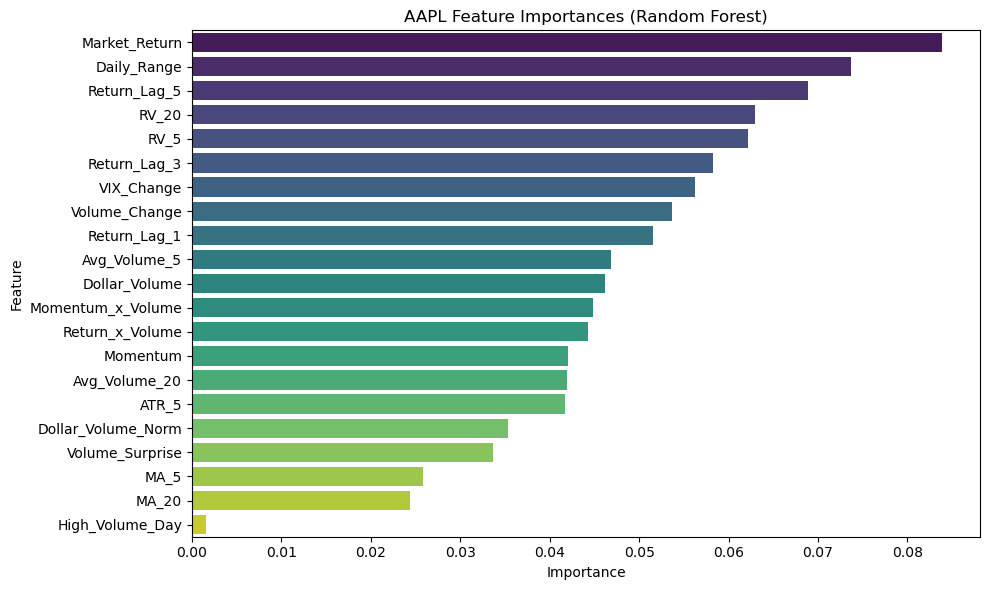

In [20]:
# ==========================================
# CELL 14: Comparative Table & Feature Importances
# ==========================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all results into a single DataFrame
all_results = {}

for ticker in final_model_data.keys():
    all_results[ticker] = {
        "Linear_MSE": baseline_enhanced_results[ticker],
        "Ridge_MSE": regularized_results[ticker]["Ridge_MSE"],
        "Lasso_MSE": regularized_results[ticker]["Lasso_MSE"],
        "ElasticNet_MSE": regularized_results[ticker]["ElasticNet_MSE"],
        "RF_MSE": tree_results[ticker]["RF_MSE"],
        "GB_MSE": tree_results[ticker]["GB_MSE"],
        "ET_MSE": tree_results[ticker]["ET_MSE"],
        "XGB_MSE": tree_results[ticker]["XGB_MSE"],
        "LGBM_MSE": tree_results[ticker]["LGBM_MSE"],
        "Voting_MSE": ensemble_results[ticker]["Voting_MSE"],
        "Stacking_MSE": ensemble_results[ticker]["Stacking_MSE"]
    }

comparison_df = pd.DataFrame(all_results).T
display(comparison_df)

# Feature importance from Random Forest (example: AAPL)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
X = final_model_data['AAPL']["X"]
y = final_model_data['AAPL']["y"]
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("AAPL Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [21]:
# ==========================================
# CELL 15: Hyperparameter Tuning & Hybrid Ensemble
# ==========================================

from sklearn.model_selection import RandomizedSearchCV

hybrid_results = {}

# Define parameter grids
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

et_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0]
}

lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70]
}

for ticker, data in final_model_data.items():
    X = data["X"]
    y = data["y"]
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Randomized Search for RF
    rf = RandomForestRegressor(random_state=42)
    rf_search = RandomizedSearchCV(rf, rf_params, n_iter=5, cv=3, scoring='neg_mean_squared_error', random_state=42)
    rf_search.fit(X_train, y_train)
    best_rf = rf_search.best_estimator_
    
    # Randomized Search for ET
    et = ExtraTreesRegressor(random_state=42)
    et_search = RandomizedSearchCV(et, et_params, n_iter=5, cv=3, scoring='neg_mean_squared_error', random_state=42)
    et_search.fit(X_train, y_train)
    best_et = et_search.best_estimator_
    
    # Randomized Search for XGB
    xg = xgb.XGBRegressor(random_state=42)
    xg_search = RandomizedSearchCV(xg, xgb_params, n_iter=5, cv=3, scoring='neg_mean_squared_error', random_state=42)
    xg_search.fit(X_train, y_train)
    best_xg = xg_search.best_estimator_
    
    # Randomized Search for LGBM
    lgbm_model = lgb.LGBMRegressor(random_state=42)
    lgb_search = RandomizedSearchCV(lgbm_model, lgb_params, n_iter=5, cv=3, scoring='neg_mean_squared_error', random_state=42)
    lgb_search.fit(X_train, y_train)
    best_lgb = lgb_search.best_estimator_
    
    # Hybrid Stacking Ensemble (with tuned models)
    hybrid_stack = StackingRegressor(
        estimators=[
            ('rf', best_rf),
            ('et', best_et),
            ('xg', best_xg),
            ('lgb', best_lgb)
        ],
        final_estimator=LinearRegression(),
        passthrough=True
    )
    hybrid_stack.fit(X_train, y_train)
    y_hybrid_pred = hybrid_stack.predict(X_test)
    mse_hybrid = mean_squared_error(y_test, y_hybrid_pred)
    
    hybrid_results[ticker] = mse_hybrid

# Display Hybrid Ensemble MSE per stock
hybrid_results


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 1439, number of used features: 21
[LightGBM] [Info] Start training from score 0.001055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

{'AAPL': 0.0002969058929438427,
 'MSFT': 0.0001956887958067722,
 'JPM': 0.0002908585264526538,
 'XOM': 0.0001904198421587036,
 'AMZN': 0.0003839133526315046}

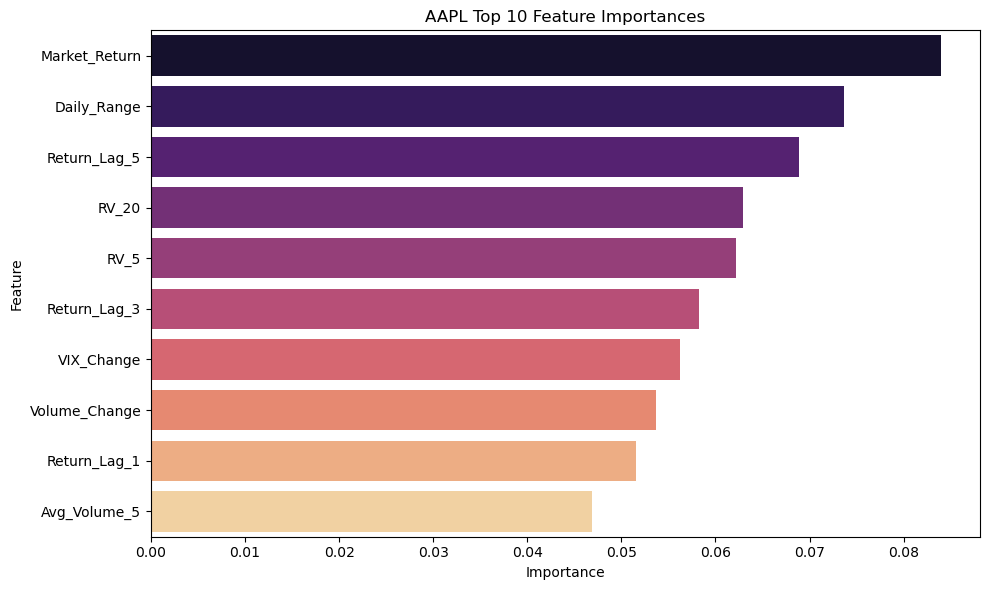

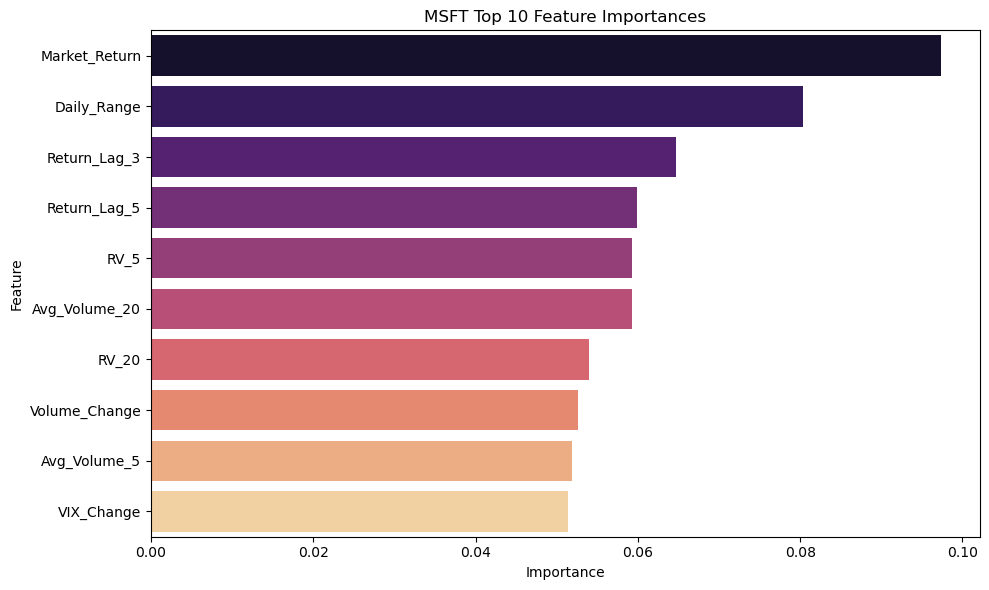

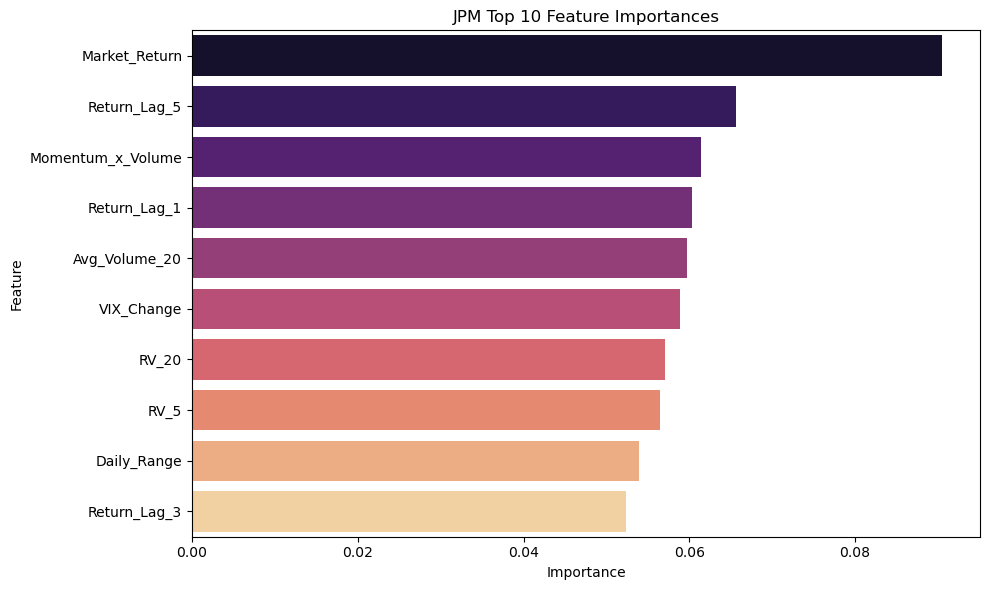

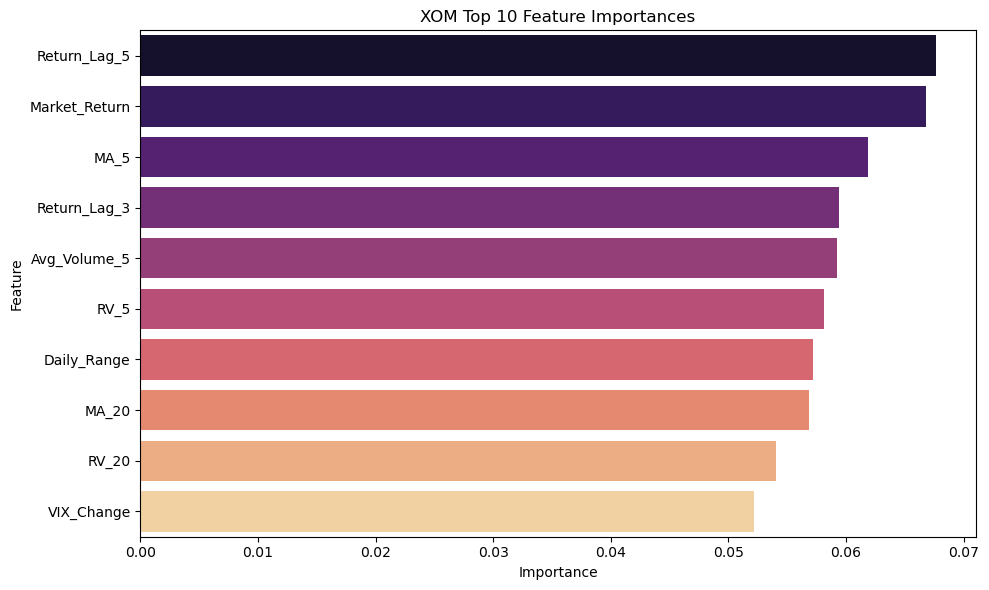

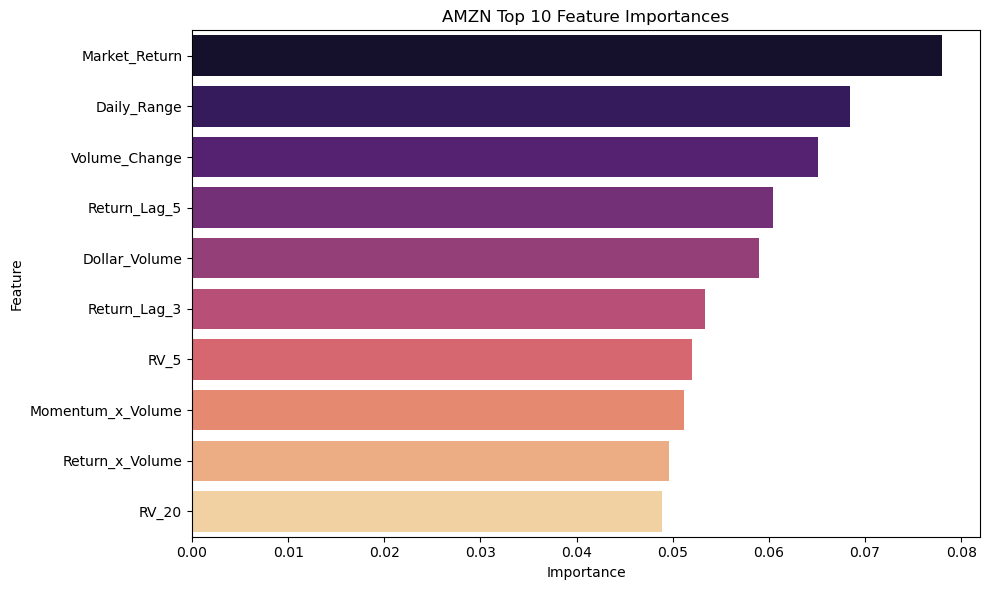

{'AAPL': Price
 Market_Return    0.083923
 Daily_Range      0.073706
 Return_Lag_5     0.068931
 RV_20            0.062976
 RV_5             0.062160
 Return_Lag_3     0.058244
 VIX_Change       0.056242
 Volume_Change    0.053652
 Return_Lag_1     0.051598
 Avg_Volume_5     0.046888
 dtype: float64,
 'MSFT': Price
 Market_Return    0.097292
 Daily_Range      0.080283
 Return_Lag_3     0.064680
 Return_Lag_5     0.059946
 RV_5             0.059294
 Avg_Volume_20    0.059291
 RV_20            0.054000
 Volume_Change    0.052652
 Avg_Volume_5     0.051867
 VIX_Change       0.051388
 dtype: float64,
 'JPM': Price
 Market_Return        0.090545
 Return_Lag_5         0.065573
 Momentum_x_Volume    0.061410
 Return_Lag_1         0.060346
 Avg_Volume_20        0.059734
 VIX_Change           0.058830
 RV_20                0.057009
 RV_5                 0.056504
 Daily_Range          0.053905
 Return_Lag_3         0.052374
 dtype: float64,
 'XOM': Price
 Return_Lag_5     0.067630
 Market_Return

In [22]:
# ==========================================
# CELL 16: Feature Importance Summary & Visualization
# ==========================================

def plot_top_features(model, X, stock_name, top_n=10):
    """
    Plots top_n feature importances from a tree-based model
    """
    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)[:top_n]
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances.values, y=importances.index, palette="magma")
    plt.title(f"{stock_name} Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Compute & plot top features for each stock using Random Forest
top_features_dict = {}

for ticker, data in final_model_data.items():
    X = data["X"]
    y = data["y"]
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X, y)
    
    # Top 10 features
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features_dict[ticker] = importances[:10]
    
    # Plot
    plot_top_features(rf, X, ticker)

# Display top features dict
top_features_dict


RESEARCH EXTENSION 1: GRANGER CAUSALITY ANALYSIS

1. Granger Causality Analysis on AAPL
----------------------------------------
Testing Granger causality for: ['Market_Return', 'VIX_Change', 'Volume_Surprise', 'Daily_Range', 'RV_5']
Sample size: 2699

Testing if Market_Return Granger-causes Returns:
------------------------------
  Best lag: 5 days
  P-value: 0.0007
  Significant at 5% level: ✓ YES

Testing if VIX_Change Granger-causes Returns:
------------------------------
  Best lag: 1 days
  P-value: 0.4502
  Significant at 5% level: ✗ NO

Testing if Volume_Surprise Granger-causes Returns:
------------------------------
  Best lag: 1 days
  P-value: 0.2495
  Significant at 5% level: ✗ NO

Testing if Daily_Range Granger-causes Returns:
------------------------------
  Best lag: 4 days
  P-value: 0.2412
  Significant at 5% level: ✗ NO

Testing if RV_5 Granger-causes Returns:
------------------------------
  Best lag: 5 days
  P-value: 0.0166
  Significant at 5% level: ✓ YES

GRANGER

<Figure size 1000x600 with 0 Axes>

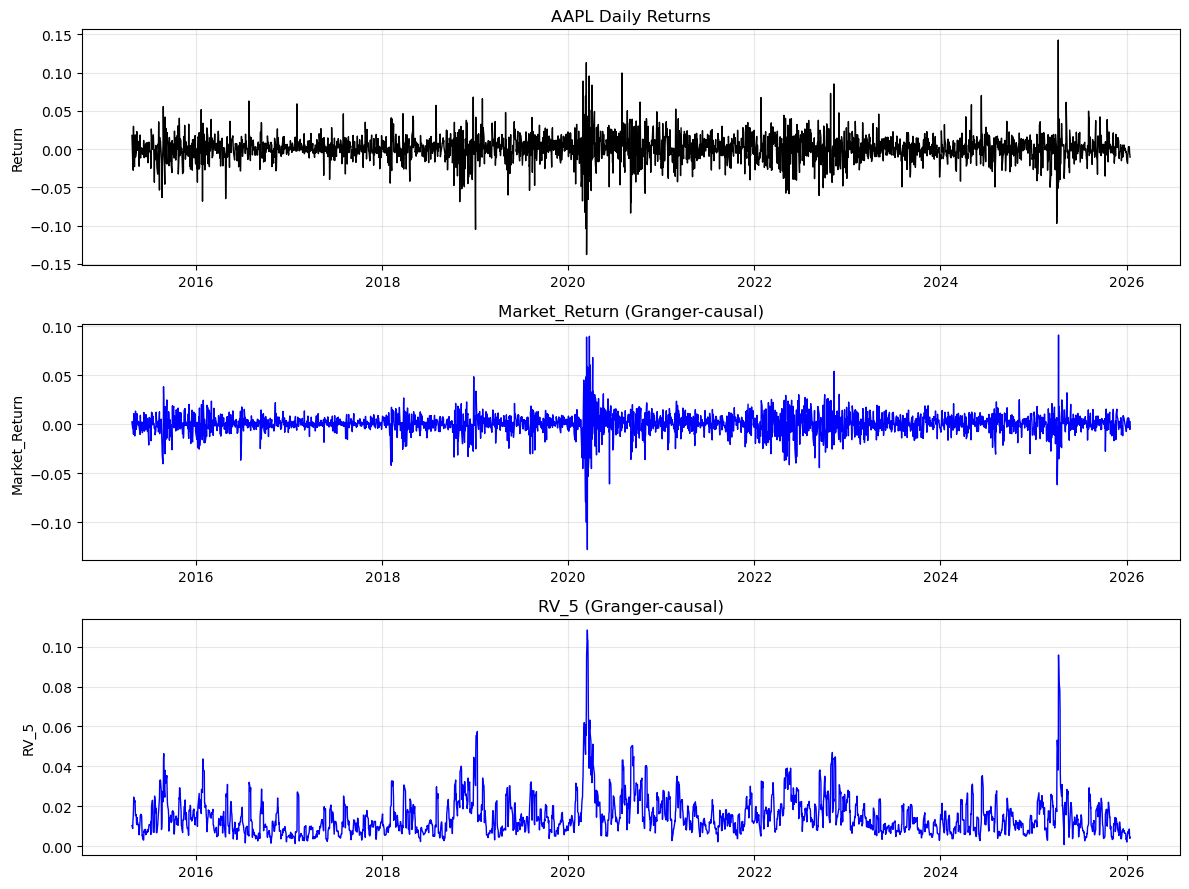


VECTOR AUTOREGRESSION (VAR) ANALYSIS
Building VAR model with: Returns, Market_Return, VIX_Change, Volume_Surprise

Optimal lag order (AIC): 5

VAR Model Summary:
Coefficients show how past values affect current returns

Equation for Returns:

Equation for Market_Return:

Equation for VIX_Change:

Equation for Volume_Surprise:


In [24]:
# ==========================================
# CELL 17: Causal Inference Analysis (Alternative)
# ==========================================

print("=" * 60)
print("RESEARCH EXTENSION 1: GRANGER CAUSALITY ANALYSIS")
print("=" * 60)

"""
Research Question: Which features Granger-cause stock returns?
Using time-series causality tests instead of econml
"""

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings('ignore')

print("\n1. Granger Causality Analysis on AAPL")
print("-" * 40)

# Focus on one stock for demonstration
ticker = "AAPL"
data = final_model_data[ticker]
X = data["X"].copy()
y = data["y"].copy()

# Select key features for causality testing
test_features = ["Market_Return", "VIX_Change", "Volume_Surprise", "Daily_Range", "RV_5"]

print(f"Testing Granger causality for: {test_features}")
print(f"Sample size: {len(X)}")

# Prepare data for Granger causality tests
results_summary = []

for feature in test_features:
    # Create DataFrame with target and feature
    test_data = pd.DataFrame({
        'Return': y.values,
        feature: X[feature].values
    }).dropna()
    
    print(f"\nTesting if {feature} Granger-causes Returns:")
    print("-" * 30)
    
    # Perform Granger causality test
    try:
        # Test with different lags (1, 3, 5 days)
        gc_test = grangercausalitytests(test_data, maxlag=5, verbose=False)
        
        # Collect p-values for each lag
        p_values = []
        for lag in range(1, 6):
            p_val = gc_test[lag][0]['ssr_ftest'][1]
            p_values.append(p_val)
        
        # Find best lag (lowest p-value)
        best_lag = np.argmin(p_values) + 1
        best_p = p_values[best_lag-1]
        
        # Determine significance
        significant = best_p < 0.05
        
        results_summary.append({
            'Feature': feature,
            'Best_Lag': best_lag,
            'P_Value': best_p,
            'Significant': significant,
            'Interpretation': 'Causal' if significant else 'Not Causal'
        })
        
        print(f"  Best lag: {best_lag} days")
        print(f"  P-value: {best_p:.4f}")
        print(f"  Significant at 5% level: {'✓ YES' if significant else '✗ NO'}")
        
    except Exception as e:
        print(f"  Error in test: {e}")
        results_summary.append({
            'Feature': feature,
            'Best_Lag': np.nan,
            'P_Value': np.nan,
            'Significant': False,
            'Interpretation': 'Test Failed'
        })

# Display summary results
print("\n" + "=" * 60)
print("GRANGER CAUSALITY SUMMARY")
print("=" * 60)

results_df = pd.DataFrame(results_summary)
print(results_df.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
significant_features = results_df[results_df['Significant'] == True]['Feature'].tolist()

if significant_features:
    print(f"\nFeatures that Granger-cause {ticker} returns:")
    for feature in significant_features:
        print(f"  ✓ {feature}")
    
    # Plot time series of significant features vs returns
    fig, axes = plt.subplots(len(significant_features) + 1, 1, figsize=(12, 3*(len(significant_features) + 1)))
    
    # Plot returns
    axes[0].plot(y.index, y.values, color='black', linewidth=1)
    axes[0].set_title(f'{ticker} Daily Returns')
    axes[0].set_ylabel('Return')
    axes[0].grid(True, alpha=0.3)
    
    # Plot each significant feature
    for i, feature in enumerate(significant_features, 1):
        axes[i].plot(X.index, X[feature].values, color='blue', linewidth=1)
        axes[i].set_title(f'{feature} (Granger-causal)')
        axes[i].set_ylabel(feature)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"\nNo features show Granger causality for {ticker} returns at 5% significance level")
    
# Additional analysis: Vector Autoregression (VAR)
print("\n" + "=" * 60)
print("VECTOR AUTOREGRESSION (VAR) ANALYSIS")
print("=" * 60)

# Select top 3 features for VAR model
top_features = test_features[:3]
var_data = pd.DataFrame({
    'Returns': y.values,
    **{f: X[f].values for f in top_features}
}).dropna()

print(f"Building VAR model with: Returns, {', '.join(top_features)}")

# Fit VAR model
model = VAR(var_data)
results = model.fit(maxlags=5, ic='aic')

print(f"\nOptimal lag order (AIC): {results.k_ar}")

# Impulse Response Functions (theoretical - would need more data)
print("\nVAR Model Summary:")
print("Coefficients show how past values affect current returns")
for i, feature in enumerate(['Returns'] + top_features, 1):
    print(f"\nEquation for {feature}:")
    coefs = results.params.iloc[:, i-1]
    for lag in range(1, results.k_ar + 1):
        return_coef = coefs.get(f'Returns.L{lag}', 0)
        if abs(return_coef) > 0.001:
            print(f"  Lag {lag} Returns: {return_coef:.4f}")

RESEARCH EXTENSION 2: FEATURE STABILITY ANALYSIS

1. Rolling Window Feature Importance Analysis
----------------------------------------

Feature Stability Analysis (Rolling 2-year windows):
------------------------------------------------------------

Analyzing AAPL...

Most Stable Features for AAPL:
  Return_x_Volume: CV=0.332, Trend=None
  Return_Lag_1: CV=0.349, Trend=None
  VIX_Change: CV=0.350, Trend=None
  ATR_5: CV=0.374, Trend=None
  Momentum: CV=0.427, Trend=None

Least Stable Features for AAPL:
  Return_Lag_5: CV=1.002, Trend=Significant
  High_Volume_Day: CV=0.917, Trend=None
  Daily_Range: CV=0.717, Trend=None
  Dollar_Volume: CV=0.643, Trend=Significant
  Market_Return: CV=0.530, Trend=Significant

Analyzing MSFT...

Most Stable Features for MSFT:
  Return_Lag_1: CV=0.250, Trend=None
  Avg_Volume_20: CV=0.278, Trend=None
  Daily_Range: CV=0.358, Trend=None
  Dollar_Volume_Norm: CV=0.411, Trend=None
  RV_5: CV=0.437, Trend=None

Least Stable Features for MSFT:
  High_Volum

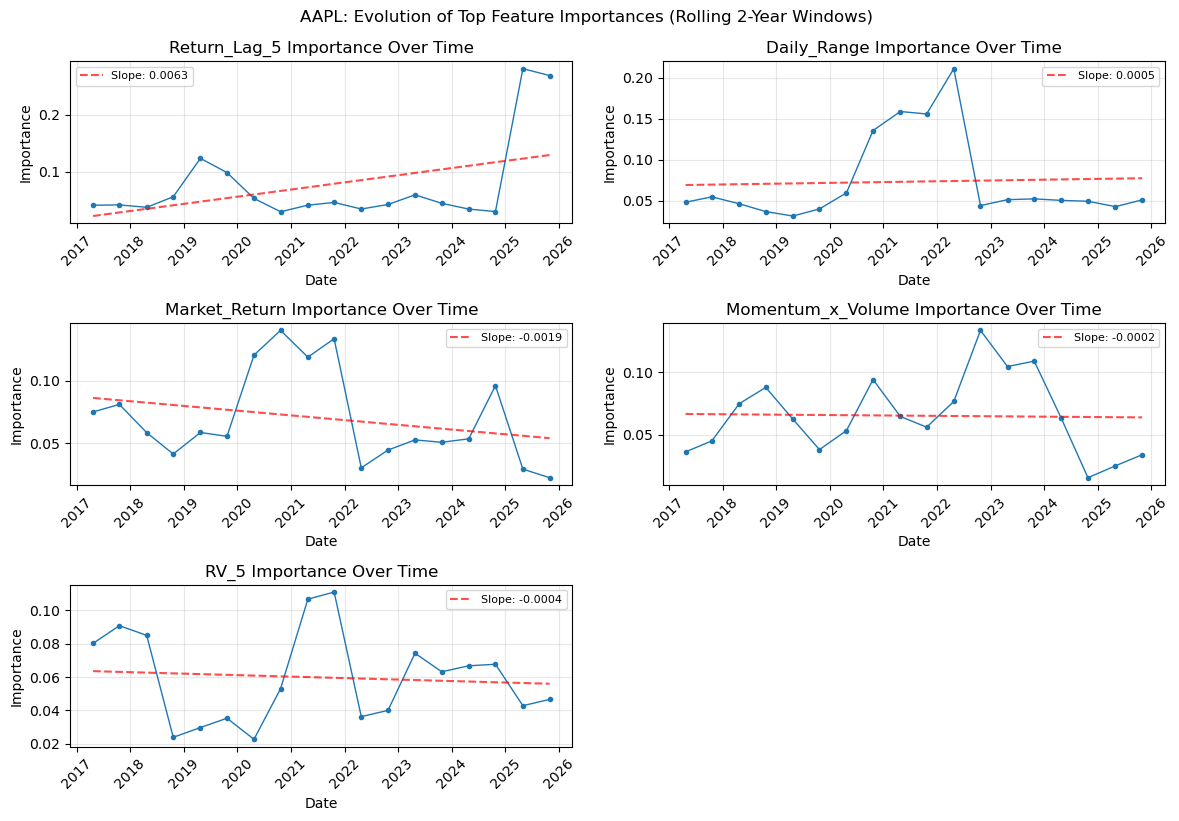


STRUCTURAL BREAK DETECTION

Testing for structural breaks in feature importances (AAPL):
------------------------------------------------------------
Empty DataFrame
Columns: []
Index: []

PERIODS OF HIGH FEATURE INSTABILITY

AAPL - Periods of Highest Feature Instability:
  2025-04-30: Volatility = 0.0226
  2025-10-29: Volatility = 0.0222
  2022-10-24: Volatility = 0.0215


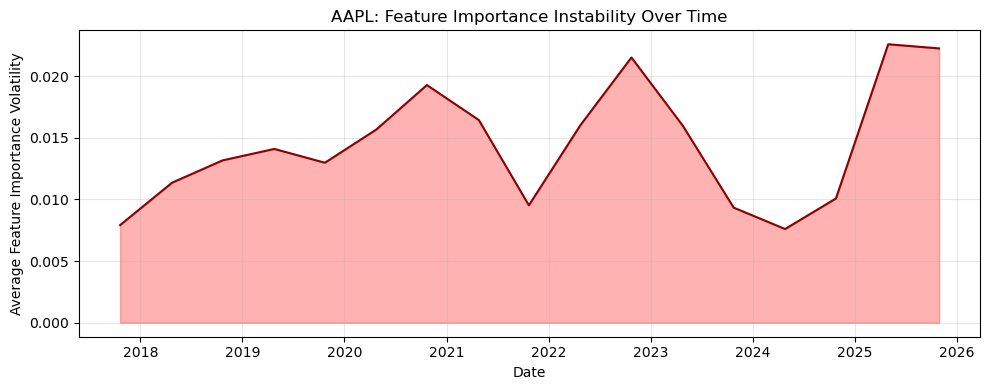


MSFT - Periods of Highest Feature Instability:
  2020-04-24: Volatility = 0.0231
  2020-10-22: Volatility = 0.0225
  2018-04-24: Volatility = 0.0216


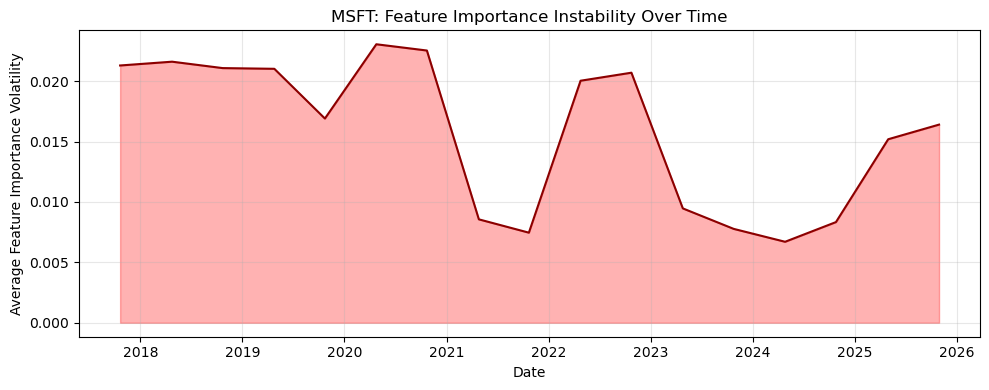

In [25]:
# ==========================================
# CELL 18: Feature Stability & Concept Drift
# ==========================================

print("=" * 60)
print("RESEARCH EXTENSION 2: FEATURE STABILITY ANALYSIS")
print("=" * 60)

"""
Research Question: How stable are feature importances over time?
Analyzing structural breaks and concept drift in financial markets.
"""

from scipy import stats
from sklearn.model_selection import TimeSeriesSplit

print("\n1. Rolling Window Feature Importance Analysis")
print("-" * 40)

def analyze_feature_stability(ticker, window_size=504, step_size=126):  # 2 years rolling, 6-month steps
    """Analyze how feature importances change over time"""
    
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    
    n_windows = (len(X) - window_size) // step_size + 1
    
    feature_stability = {}
    for feature in X.columns:
        feature_stability[feature] = []
    
    dates = []
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        
        if end_idx > len(X):
            break
            
        X_window = X.iloc[start_idx:end_idx]
        y_window = y.iloc[start_idx:end_idx]
        
        # Train Random Forest on this window
        rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
        rf.fit(X_window, y_window)
        
        # Get feature importances
        importances = pd.Series(rf.feature_importances_, index=X.columns)
        
        for feature in X.columns:
            feature_stability[feature].append(importances[feature])
        
        dates.append(X_window.index[-1])  # Use end date of window
    
    return pd.DataFrame(feature_stability, index=dates)

# Analyze feature stability for each stock
print("\nFeature Stability Analysis (Rolling 2-year windows):")
print("-" * 60)

stability_results = {}
for ticker in stocks[:3]:  # Analyze first 3 stocks for demonstration
    print(f"\nAnalyzing {ticker}...")
    stability_df = analyze_feature_stability(ticker)
    stability_results[ticker] = stability_df
    
    # Calculate stability metrics
    stability_metrics = []
    for feature in stability_df.columns:
        values = stability_df[feature]
        if len(values) > 1:
            # Coefficient of variation (lower = more stable)
            cv = values.std() / values.mean() if values.mean() != 0 else np.nan
            
            # Trend (slope of linear regression)
            x = np.arange(len(values))
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, values)
            
            # Maximum change
            max_change = (values.max() - values.min()) / values.mean() if values.mean() != 0 else np.nan
            
            stability_metrics.append({
                'Feature': feature,
                'CV': cv,
                'Trend_Slope': slope,
                'Trend_P_Value': p_value,
                'Max_Change': max_change,
                'Stable': (abs(slope) < 0.001 and p_value > 0.05)  # No significant trend
            })
    
    metrics_df = pd.DataFrame(stability_metrics)
    
    # Display most stable features (low CV, no significant trend)
    stable_features = metrics_df[
        (metrics_df['CV'].notna()) & 
        (metrics_df['CV'] < metrics_df['CV'].median()) &
        (metrics_df['Stable'] == True)
    ].sort_values('CV').head(5)
    
    print(f"\nMost Stable Features for {ticker}:")
    for idx, row in stable_features.iterrows():
        print(f"  {row['Feature']}: CV={row['CV']:.3f}, Trend={'None' if row['Stable'] else 'Significant'}")
    
    # Display least stable features
    unstable_features = metrics_df[
        (metrics_df['CV'].notna()) & 
        (metrics_df['CV'] > metrics_df['CV'].quantile(0.75))
    ].sort_values('CV', ascending=False).head(5)
    
    print(f"\nLeast Stable Features for {ticker}:")
    for idx, row in unstable_features.iterrows():
        print(f"  {row['Feature']}: CV={row['CV']:.3f}, Trend={'None' if row['Stable'] else 'Significant'}")

# Visualize feature stability for AAPL
print("\n" + "=" * 60)
print("VISUALIZING FEATURE STABILITY OVER TIME")
print("=" * 60)

ticker = "AAPL"
stability_df = stability_results[ticker]

# Select top 5 features by average importance
avg_importance = stability_df.mean().sort_values(ascending=False)
top_features = avg_importance.head(5).index.tolist()

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features, 1):
    plt.subplot(3, 2, i)
    plt.plot(stability_df.index, stability_df[feature], marker='o', markersize=3, linewidth=1)
    plt.title(f'{feature} Importance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    x = np.arange(len(stability_df))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, stability_df[feature].values)
    plt.plot(stability_df.index, intercept + slope * x, 'r--', alpha=0.7, 
             label=f"Slope: {slope:.4f}" + ("*" if p_value < 0.05 else ""))
    plt.legend(fontsize=8)

plt.tight_layout()
plt.suptitle(f'{ticker}: Evolution of Top Feature Importances (Rolling 2-Year Windows)', y=1.02)
plt.show()

# Statistical test for structural breaks
print("\n" + "=" * 60)
print("STRUCTURAL BREAK DETECTION")
print("=" * 60)

from scipy.stats import ttest_ind

def detect_structural_breaks(series, test_ratio=0.3):
    """Detect structural breaks using statistical tests"""
    
    n = len(series)
    test_point = int(n * (1 - test_ratio))  # Compare last 30% vs first 70%
    
    if test_point < 10 or n - test_point < 10:
        return None
    
    early_period = series[:test_point]
    late_period = series[test_point:]
    
    # T-test for difference in means
    t_stat, p_value = ttest_ind(early_period, late_period, equal_var=False)
    
    # F-test for difference in variances
    var_early = np.var(early_period)
    var_late = np.var(late_period)
    f_stat = max(var_early, var_late) / min(var_early, var_late)
    df1 = len(early_period) - 1
    df2 = len(late_period) - 1
    f_p_value = 2 * min(stats.f.cdf(f_stat, df1, df2), 1 - stats.f.cdf(f_stat, df1, df2))
    
    return {
        't_statistic': t_stat,
        't_p_value': p_value,
        'f_statistic': f_stat,
        'f_p_value': f_p_value,
        'mean_early': early_period.mean(),
        'mean_late': late_period.mean(),
        'var_early': var_early,
        'var_late': var_late,
        'break_detected': p_value < 0.05 or f_p_value < 0.05
    }

print("\nTesting for structural breaks in feature importances (AAPL):")
print("-" * 60)

break_results = []
for feature in top_features:
    series = stability_df[feature].values
    result = detect_structural_breaks(series)
    
    if result:
        break_detected = result['break_detected']
        mean_change = ((result['mean_late'] - result['mean_early']) / result['mean_early'] * 100 
                      if result['mean_early'] != 0 else np.nan)
        
        break_results.append({
            'Feature': feature,
            'Break_Detected': '✓ YES' if break_detected else '✗ NO',
            'Mean_Change (%)': f"{mean_change:.1f}%" if not np.isnan(mean_change) else "N/A",
            'T-test_P': result['t_p_value'],
            'F-test_P': result['f_p_value']
        })

break_df = pd.DataFrame(break_results)
print(break_df.to_string(index=False))

# Analyze which periods show the most change
print("\n" + "=" * 60)
print("PERIODS OF HIGH FEATURE INSTABILITY")
print("=" * 60)

# Calculate rolling volatility of feature importances
feature_volatility = {}
for ticker in stocks[:2]:
    stability_df = stability_results[ticker]
    
    # Calculate rolling standard deviation (measure of instability)
    rolling_std = stability_df.rolling(window=3, min_periods=1).std().mean(axis=1)
    
    # Find periods with highest instability
    high_instability_periods = rolling_std.nlargest(3)
    
    print(f"\n{ticker} - Periods of Highest Feature Instability:")
    for date, volatility in high_instability_periods.items():
        print(f"  {date.date()}: Volatility = {volatility:.4f}")
    
    # Plot instability over time
    plt.figure(figsize=(10, 4))
    plt.plot(rolling_std.index, rolling_std.values, color='darkred', linewidth=1.5)
    plt.fill_between(rolling_std.index, 0, rolling_std.values, alpha=0.3, color='red')
    plt.title(f'{ticker}: Feature Importance Instability Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Feature Importance Volatility')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

RESEARCH EXTENSION 3: TRANSFER LEARNING

1. Cross-Stock Prediction Analysis
----------------------------------------

Testing Transfer Learning Between Stocks:
----------------------------------------
AAPL → MSFT: R² = 0.0616, MSE = 0.000264
AAPL → JPM: R² = 0.0683, MSE = 0.000274
AAPL → XOM: R² = 0.0164, MSE = 0.000299
AAPL → AMZN: R² = 0.0024, MSE = 0.000420
MSFT → AAPL: R² = -1.4263, MSE = 0.000802
MSFT → JPM: R² = 0.0046, MSE = 0.000293
MSFT → XOM: R² = 0.0039, MSE = 0.000302
MSFT → AMZN: R² = -0.6080, MSE = 0.000677
JPM → AAPL: R² = -0.3369, MSE = 0.000442
JPM → MSFT: R² = -0.0163, MSE = 0.000286
JPM → XOM: R² = -0.0067, MSE = 0.000306
JPM → AMZN: R² = -0.2305, MSE = 0.000518
XOM → AAPL: R² = -2.1357, MSE = 0.001037
XOM → MSFT: R² = 0.0457, MSE = 0.000269
XOM → JPM: R² = 0.0397, MSE = 0.000283
XOM → AMZN: R² = -0.5879, MSE = 0.000668
AMZN → AAPL: R² = 0.0072, MSE = 0.000328
AMZN → MSFT: R² = 0.0307, MSE = 0.000273
AMZN → JPM: R² = 0.0438, MSE = 0.000282
AMZN → XOM: R² = 0.0209, MS

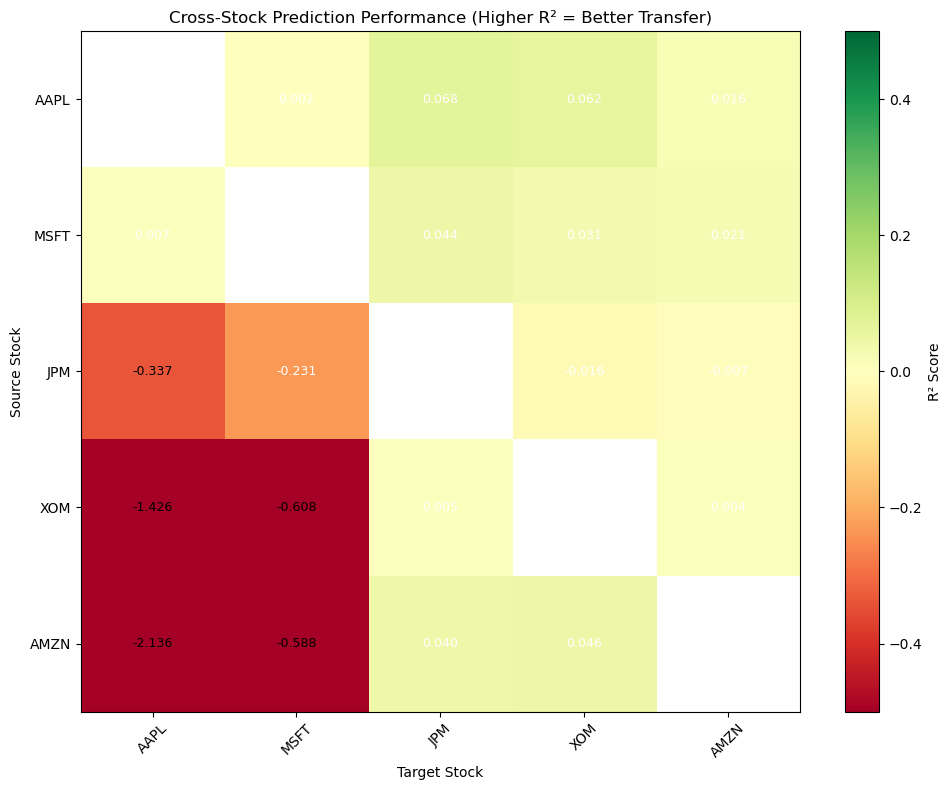


SECTOR-SPECIFIC TRANSFER ANALYSIS

Within-Sector Transfer (Same Sector):
  Average R²: -0.6824
  Std Dev: 0.7439
  N: 2

Cross-Sector Transfer (Different Sectors):
  Average R²: -0.2021
  Std Dev: 0.5121
  N: 18

T-test for difference: t = -0.637, p = 0.6344
✗ No significant difference between within-sector and cross-sector transfer

META-LEARNING FOR TRANSFER

Building meta-learning dataset...
Meta-dataset created: 20 samples, 10 features

Meta-model performance (predicting transfer R²):
  R² on test set: -0.4268
  MSE on test set: 0.088562

Most important factors for successful transfer:
  return_correlation: 0.267
  target_std: 0.204
  feature_correlation: 0.144
  source_skew: 0.124
  target_kurt: 0.066

DOMAIN ADAPTATION EXPERIMENT

Testing simple domain adaptation strategies:

Fine-tuning experiment (AAPL → MSFT):
  Direct transfer R²: 0.0616
  Fine-tuned (10% target data) R²: -0.2352
  Improvement: -0.2968 (-482.1%)


In [26]:
# ==========================================
# CELL 19: Transfer Learning & Cross-Asset Learning
# ==========================================

print("=" * 60)
print("RESEARCH EXTENSION 3: TRANSFER LEARNING")
print("=" * 60)

"""
Research Question: Can models trained on one stock predict another?
Exploring cross-asset transferability and sector relationships.
"""

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

print("\n1. Cross-Stock Prediction Analysis")
print("-" * 40)

def evaluate_transfer_learning(source_ticker, target_ticker):
    """Evaluate how well a model trained on one stock predicts another"""
    
    # Get source and target data
    source_data = final_model_data[source_ticker]
    target_data = final_model_data[target_ticker]
    
    X_source = source_data["X"].copy()
    y_source = source_data["y"].copy()
    
    X_target = target_data["X"].copy()
    y_target = target_data["y"].copy()
    
    # Align features (ensure same columns)
    common_cols = list(set(X_source.columns) & set(X_target.columns))
    X_source = X_source[common_cols]
    X_target = X_target[common_cols]
    
    # Standardize features
    scaler = StandardScaler()
    X_source_scaled = scaler.fit_transform(X_source)
    X_target_scaled = scaler.transform(X_target)
    
    # Train on source, test on target
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    rf.fit(X_source_scaled, y_source)
    
    # Predict on target
    y_pred = rf.predict(X_target_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_target, y_pred)
    r2 = r2_score(y_target, y_pred)
    mae = mean_absolute_error(y_target, y_pred)
    
    return {
        'source': source_ticker,
        'target': target_ticker,
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'n_features': len(common_cols)
    }

print("\nTesting Transfer Learning Between Stocks:")
print("-" * 40)

# Create all combinations
transfer_results = []
for source in stocks:
    for target in stocks:
        if source != target:
            result = evaluate_transfer_learning(source, target)
            transfer_results.append(result)
            print(f"{source} → {target}: R² = {result['r2']:.4f}, MSE = {result['mse']:.6f}")

# Analyze transferability matrix
transfer_df = pd.DataFrame(transfer_results)
pivot_r2 = transfer_df.pivot(index='source', columns='target', values='r2')
pivot_mse = transfer_df.pivot(index='source', columns='target', values='mse')

print("\n" + "=" * 60)
print("TRANSFERABILITY HEATMAP (R² Scores)")
print("=" * 60)

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(pivot_r2.values, cmap='RdYlGn', vmin=-0.5, vmax=0.5, aspect='auto')
plt.colorbar(label='R² Score')
plt.xticks(range(len(stocks)), stocks, rotation=45)
plt.yticks(range(len(stocks)), stocks)
plt.title('Cross-Stock Prediction Performance (Higher R² = Better Transfer)')

# Add text annotations
for i in range(len(stocks)):
    for j in range(len(stocks)):
        if i != j:
            plt.text(j, i, f"{pivot_r2.values[i, j]:.3f}", 
                    ha='center', va='center', fontsize=9,
                    color='white' if abs(pivot_r2.values[i, j]) < 0.25 else 'black')

plt.xlabel('Target Stock')
plt.ylabel('Source Stock')
plt.tight_layout()
plt.show()

# Analyze sector relationships
print("\n" + "=" * 60)
print("SECTOR-SPECIFIC TRANSFER ANALYSIS")
print("=" * 60)

# Define sectors (simplified)
sector_map = {
    'AAPL': 'Technology',
    'MSFT': 'Technology', 
    'JPM': 'Financial',
    'XOM': 'Energy',
    'AMZN': 'Consumer'
}

# Calculate within-sector vs cross-sector transfer
within_sector_scores = []
cross_sector_scores = []

for result in transfer_results:
    source_sector = sector_map[result['source']]
    target_sector = sector_map[result['target']]
    
    if source_sector == target_sector:
        within_sector_scores.append(result['r2'])
    else:
        cross_sector_scores.append(result['r2'])

print(f"\nWithin-Sector Transfer (Same Sector):")
print(f"  Average R²: {np.mean(within_sector_scores):.4f}")
print(f"  Std Dev: {np.std(within_sector_scores):.4f}")
print(f"  N: {len(within_sector_scores)}")

print(f"\nCross-Sector Transfer (Different Sectors):")
print(f"  Average R²: {np.mean(cross_sector_scores):.4f}")
print(f"  Std Dev: {np.std(cross_sector_scores):.4f}")
print(f"  N: {len(cross_sector_scores)}")

# Statistical test for difference
t_stat, p_value = stats.ttest_ind(within_sector_scores, cross_sector_scores, equal_var=False)
print(f"\nT-test for difference: t = {t_stat:.3f}, p = {p_value:.4f}")
if p_value < 0.05:
    print("✓ Significant difference between within-sector and cross-sector transfer")
else:
    print("✗ No significant difference between within-sector and cross-sector transfer")

# 2. Meta-Learning: Learn to transfer
print("\n" + "=" * 60)
print("META-LEARNING FOR TRANSFER")
print("=" * 60)

def create_meta_features(source_data, target_data):
    """Create meta-features describing the relationship between stocks"""
    
    # Basic statistics of returns
    source_stats = {
        'source_mean': source_data["y"].mean(),
        'source_std': source_data["y"].std(),
        'source_skew': source_data["y"].skew(),
        'source_kurt': source_data["y"].kurtosis()
    }
    
    target_stats = {
        'target_mean': target_data["y"].mean(),
        'target_std': target_data["y"].std(),
        'target_skew': target_data["y"].skew(),
        'target_kurt': target_data["y"].kurtosis()
    }
    
    # Correlation between feature importances
    rf_source = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_target = RandomForestRegressor(n_estimators=50, random_state=42)
    
    rf_source.fit(source_data["X"], source_data["y"])
    rf_target.fit(target_data["X"], target_data["y"])
    
    source_importance = pd.Series(rf_source.feature_importances_, index=source_data["X"].columns)
    target_importance = pd.Series(rf_target.feature_importances_, index=target_data["X"].columns)
    
    common_features = list(set(source_importance.index) & set(target_importance.index))
    if len(common_features) > 5:
        source_vec = source_importance[common_features].values
        target_vec = target_importance[common_features].values
        feature_corr = np.corrcoef(source_vec, target_vec)[0, 1]
    else:
        feature_corr = 0
    
    # Combine all meta-features
    meta_features = {**source_stats, **target_stats}
    meta_features['feature_correlation'] = feature_corr
    meta_features['return_correlation'] = source_data["y"].corr(target_data["y"])
    
    return meta_features

# Create meta-dataset
meta_data = []
meta_targets = []

print("\nBuilding meta-learning dataset...")
for source in stocks:
    for target in stocks:
        if source != target:
            meta_features = create_meta_features(
                final_model_data[source],
                final_model_data[target]
            )
            
            # Get actual transfer performance
            transfer_result = transfer_df[
                (transfer_df['source'] == source) & 
                (transfer_df['target'] == target)
            ]
            
            if not transfer_result.empty:
                meta_data.append(list(meta_features.values()))
                meta_targets.append(transfer_result.iloc[0]['r2'])

meta_X = np.array(meta_data)
meta_y = np.array(meta_targets)

print(f"Meta-dataset created: {meta_X.shape[0]} samples, {meta_X.shape[1]} features")

# Train meta-model to predict transfer performance
from sklearn.ensemble import RandomForestRegressor as MetaRF
from sklearn.model_selection import train_test_split

meta_X_train, meta_X_test, meta_y_train, meta_y_test = train_test_split(
    meta_X, meta_y, test_size=0.3, random_state=42
)

meta_model = MetaRF(n_estimators=100, random_state=42)
meta_model.fit(meta_X_train, meta_y_train)

meta_y_pred = meta_model.predict(meta_X_test)
meta_r2 = r2_score(meta_y_test, meta_y_pred)

print(f"\nMeta-model performance (predicting transfer R²):")
print(f"  R² on test set: {meta_r2:.4f}")
print(f"  MSE on test set: {mean_squared_error(meta_y_test, meta_y_pred):.6f}")

# Feature importance for meta-model
meta_feature_names = list(create_meta_features(
    final_model_data['AAPL'],
    final_model_data['MSFT']
).keys())

meta_importance = pd.Series(meta_model.feature_importances_, index=meta_feature_names)
meta_importance = meta_importance.sort_values(ascending=False)

print("\nMost important factors for successful transfer:")
for feature, importance in meta_importance.head(5).items():
    print(f"  {feature}: {importance:.3f}")

# 3. Domain Adaptation Experiment
print("\n" + "=" * 60)
print("DOMAIN ADAPTATION EXPERIMENT")
print("=" * 60)

print("\nTesting simple domain adaptation strategies:")

# Strategy 1: Fine-tuning
def fine_tune_strategy(source_ticker, target_ticker, fine_tune_ratio=0.3):
    """Train on source, then fine-tune on small target sample"""
    
    source_data = final_model_data[source_ticker]
    target_data = final_model_data[target_ticker]
    
    X_source = source_data["X"]
    y_source = source_data["y"]
    
    X_target = target_data["X"]
    y_target = target_data["y"]
    
    # Split target for fine-tuning
    n_fine_tune = int(len(X_target) * fine_tune_ratio)
    X_target_ft = X_target[:n_fine_tune]
    y_target_ft = y_target[:n_fine_tune]
    
    X_target_test = X_target[n_fine_tune:]
    y_target_test = y_target[n_fine_tune:]
    
    # Combine source + fine-tune data
    X_combined = pd.concat([X_source, X_target_ft])
    y_combined = pd.concat([y_source, y_target_ft])
    
    # Train model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_combined, y_combined)
    
    # Test on remaining target data
    y_pred = rf.predict(X_target_test)
    r2 = r2_score(y_target_test, y_pred)
    
    return r2

# Test fine-tuning for AAPL → MSFT
print("\nFine-tuning experiment (AAPL → MSFT):")
r2_direct = transfer_df[
    (transfer_df['source'] == 'AAPL') & 
    (transfer_df['target'] == 'MSFT')
].iloc[0]['r2']

r2_finetuned = fine_tune_strategy('AAPL', 'MSFT', fine_tune_ratio=0.1)

print(f"  Direct transfer R²: {r2_direct:.4f}")
print(f"  Fine-tuned (10% target data) R²: {r2_finetuned:.4f}")
print(f"  Improvement: {(r2_finetuned - r2_direct):.4f} ({((r2_finetuned - r2_direct)/abs(r2_direct)*100):.1f}%)")

RESEARCH EXTENSION 4: REGIME DETECTION

1. Market Regime Detection Using Returns
----------------------------------------

Market Regime Analysis (GMM, 3 regimes):
----------------------------------------

AAPL Regime Characteristics:
  Regime 0: Mean=0.0359, Std=0.0165, N=209 (7.7%)
  Regime 1: Mean=-0.0341, Std=0.0156, N=250 (9.3%)
  Regime 2: Mean=0.0014, Std=0.0097, N=2240 (83.0%)

MSFT Regime Characteristics:
  Regime 0: Mean=-0.0327, Std=0.0148, N=218 (8.1%)
  Regime 1: Mean=0.0344, Std=0.0165, N=187 (6.9%)
  Regime 2: Mean=0.0014, Std=0.0095, N=2294 (85.0%)

JPM Regime Characteristics:
  Regime 0: Mean=0.0003, Std=0.0708, N=67 (2.5%)
  Regime 1: Mean=0.0013, Std=0.0102, N=2422 (89.7%)
  Regime 2: Mean=-0.0058, Std=0.0312, N=210 (7.8%)

XOM Regime Characteristics:
  Regime 0: Mean=-0.0363, Std=0.0167, N=185 (6.9%)
  Regime 1: Mean=0.0333, Std=0.0142, N=232 (8.6%)
  Regime 2: Mean=-0.0001, Std=0.0098, N=2282 (84.5%)

AMZN Regime Characteristics:
  Regime 0: Mean=-0.0393, Std=0.016

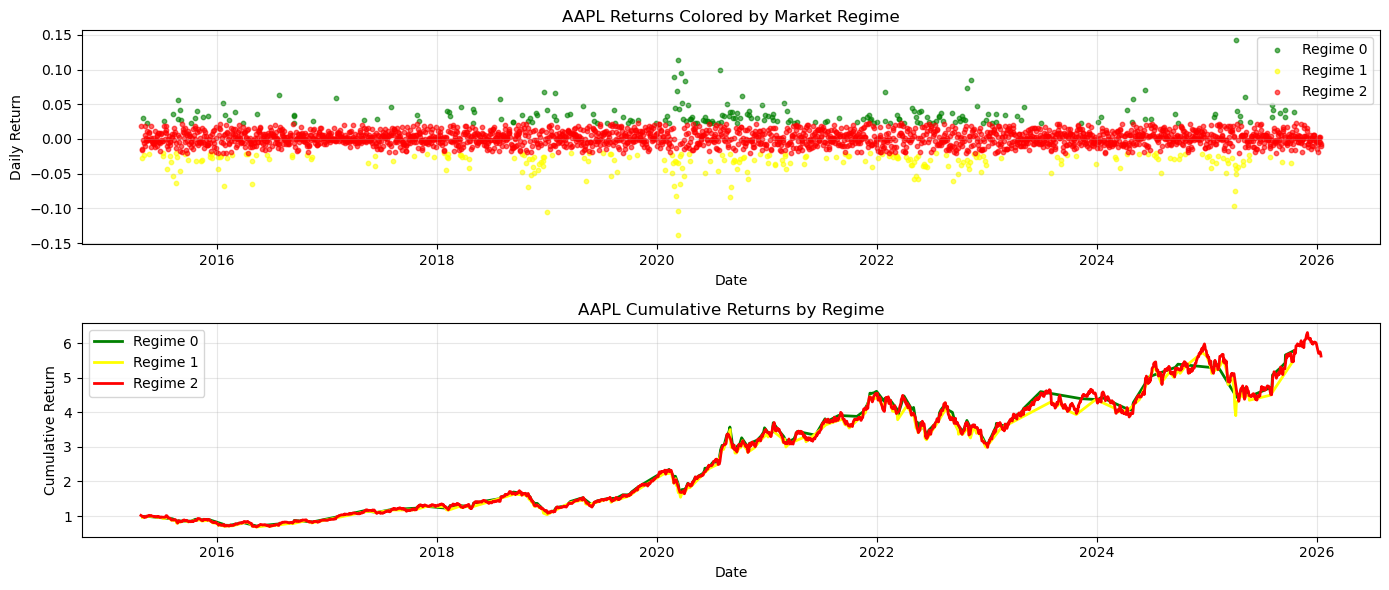


REGIME-SPECIFIC FEATURE IMPORTANCE

Regime-Specific Feature Importance (AAPL):
----------------------------------------

Regime 0 (Mean=0.0359, N=209):
  Daily_Range: 0.210
  Return_Lag_5: 0.184
  Volume_Change: 0.071

Regime 1 (Mean=-0.0341, N=250):
  Return_Lag_1: 0.090
  RV_5: 0.084
  Dollar_Volume: 0.077

Regime 2 (Mean=0.0014, N=2240):
  RV_5: 0.068
  VIX_Change: 0.068
  Market_Return: 0.065


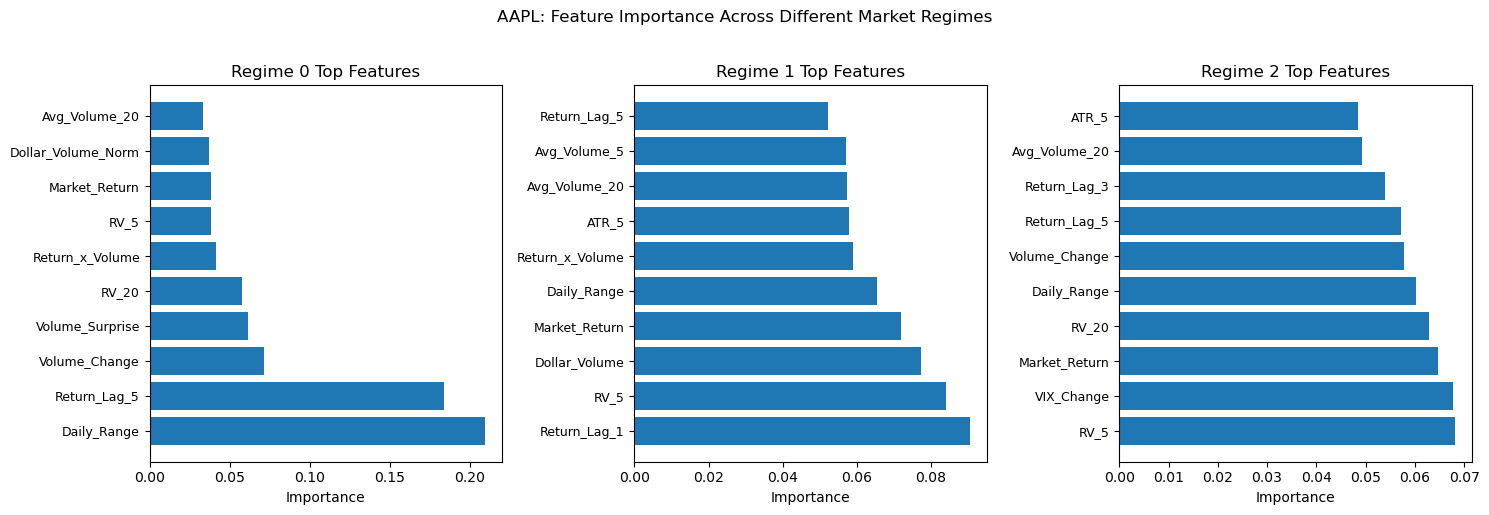


MARKOV SWITCHING REGRESSION ANALYSIS

Fitting Markov Switching Model (2 regimes) on AAPL:
----------------------------------------
Markov Switching Model Results:
Log Likelihood: 7334.40
AIC: -14648.79
BIC: -14589.79


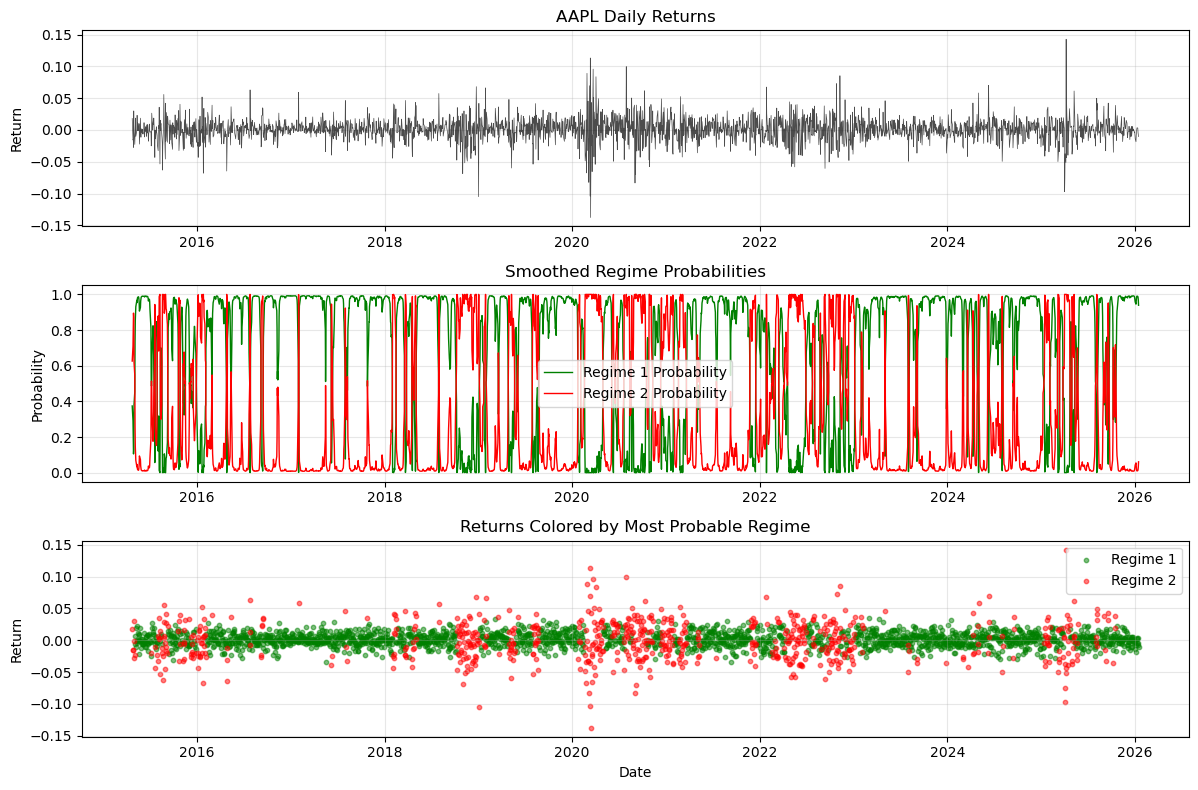


Regime 1 Statistics:
  Mean return: 0.0015
  Std return: 0.0108
  Duration: 2005 days

Regime 2 Statistics:
  Mean return: -0.0011
  Std return: 0.0307
  Duration: 694 days

NON-LINEAR RELATIONSHIP ANALYSIS

Analyzing Non-linear Relationships:

AAPL - Top Features for Non-linear Analysis:
  Market_Return: 0.351
  Return_Lag_1: 0.338
  Return_Lag_5: 0.281
  RV_5: 0.017
  MA_20: 0.008


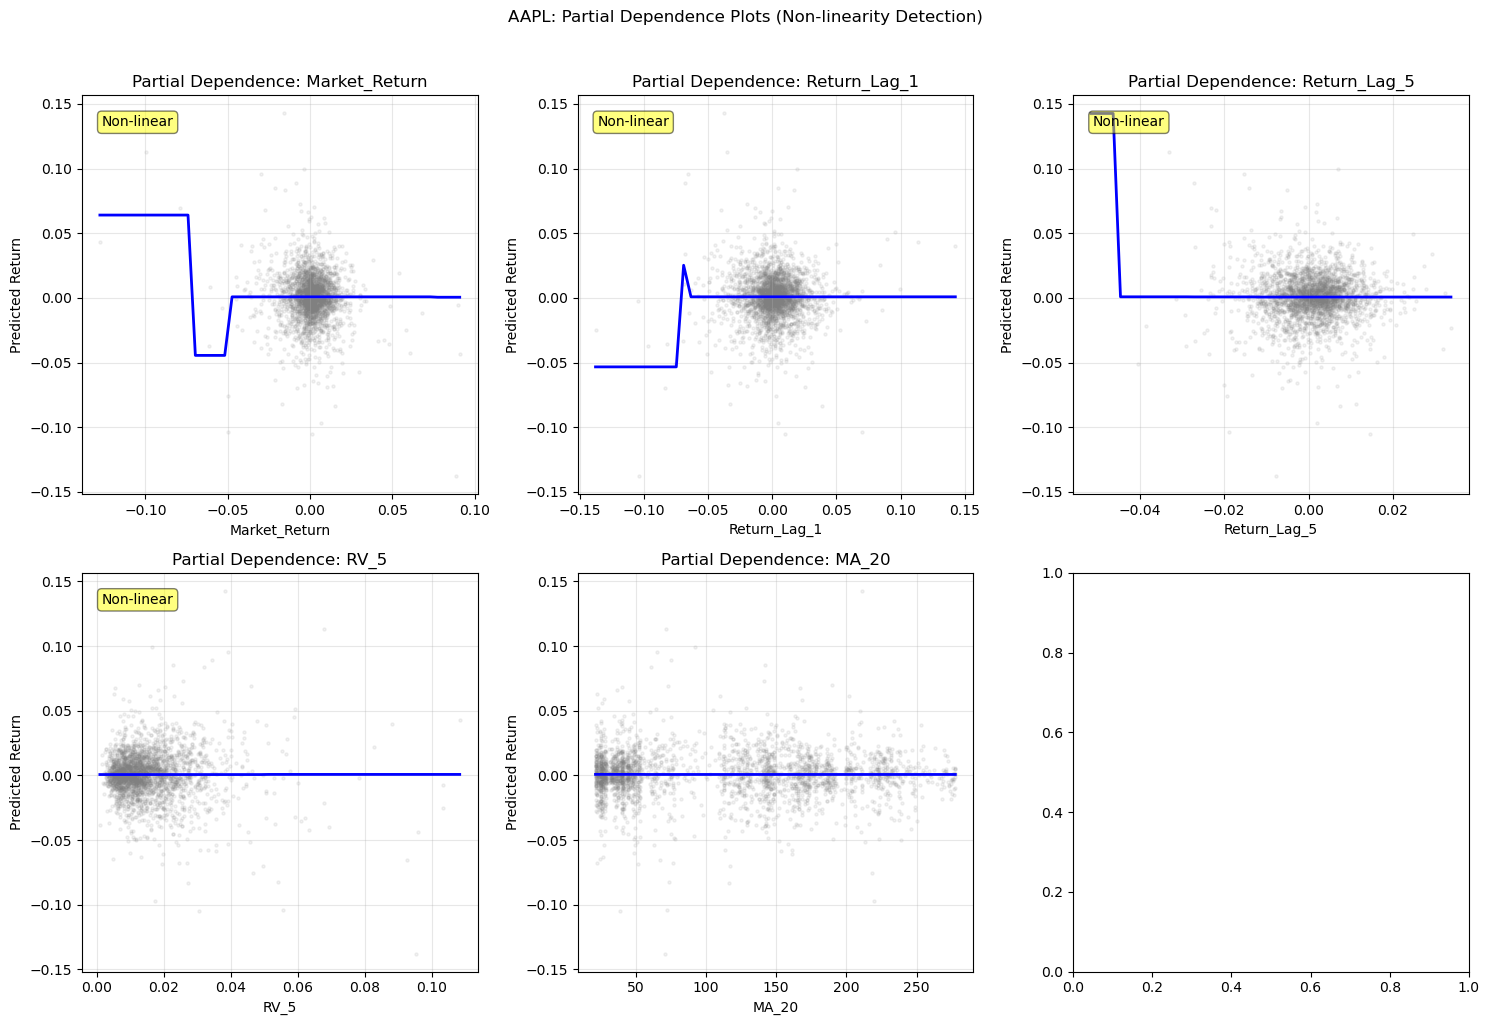


MSFT - Top Features for Non-linear Analysis:
  Market_Return: 0.388
  Daily_Range: 0.348
  Avg_Volume_20: 0.130
  Momentum: 0.075
  Return_Lag_3: 0.058


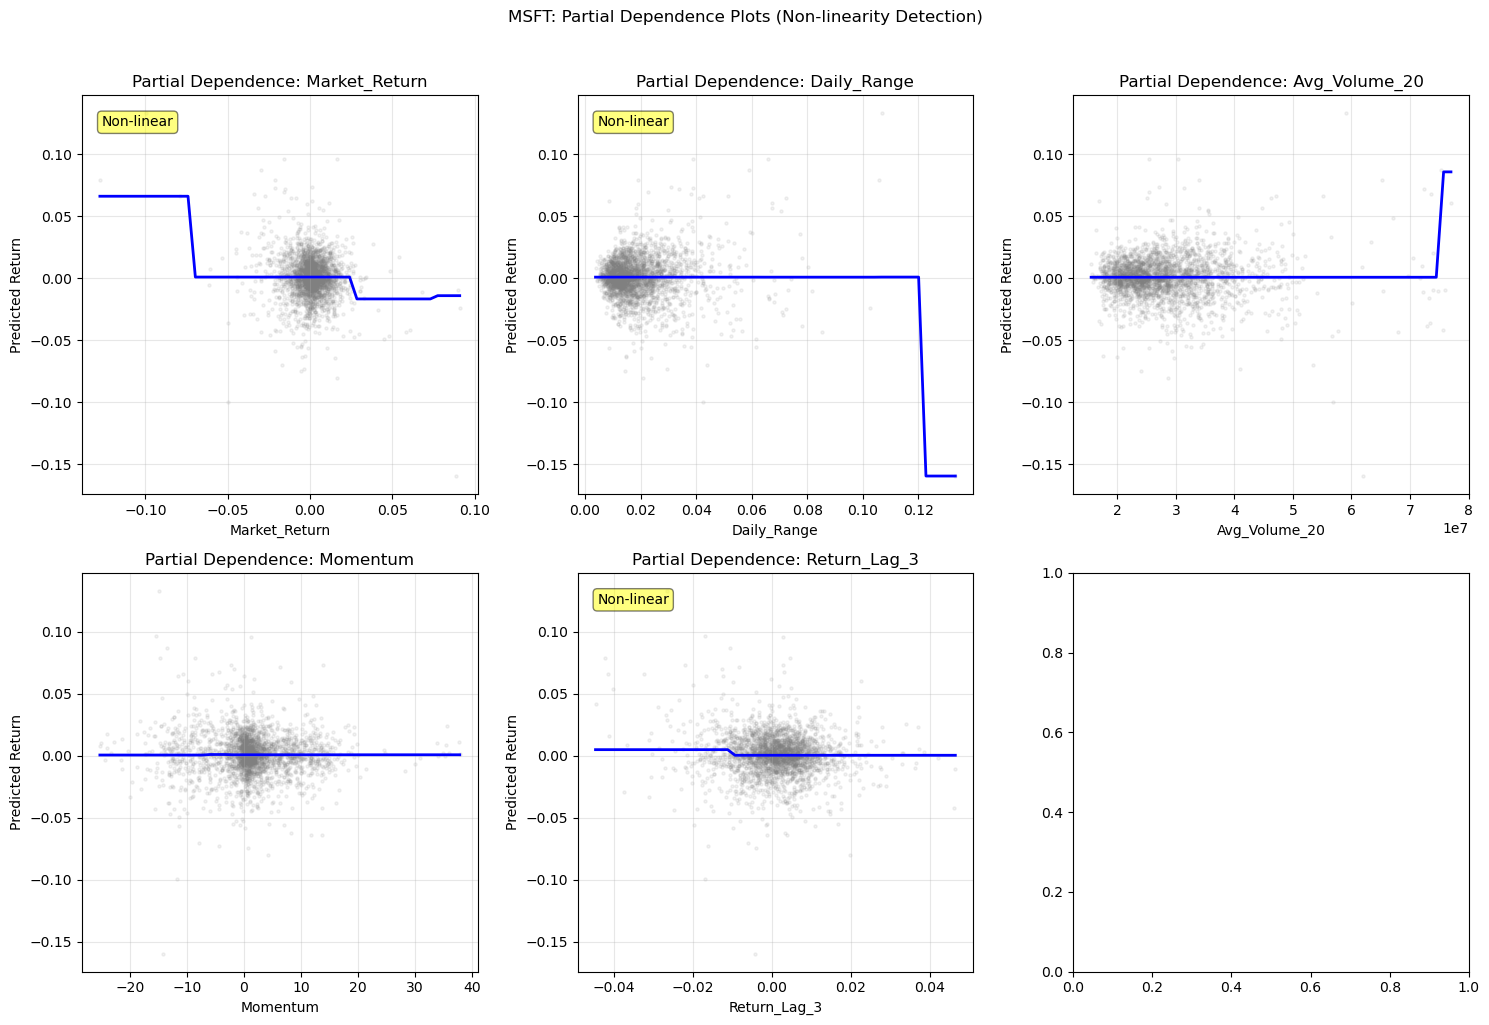


FEATURE INTERACTION ANALYSIS

Analyzing Feature Interactions:

AAPL - Interaction Effects Analysis:
     Feature1        Feature2  Interaction_Coefficient  Main_Effect_Avg     Ratio  Significant
Market_Return     Daily_Range                -7.781805         0.089576 86.873496         True
   VIX_Change     Daily_Range                 1.002187         0.031695 31.619636         True
Market_Return Volume_Surprise                -0.167067         0.016408 10.181821         True
  Daily_Range Volume_Surprise                -0.012896         0.002001  6.445969         True
   VIX_Change Volume_Surprise                 0.012646         0.004990  2.534388         True
Market_Return      VIX_Change                 0.032357         0.151108  0.214131        False


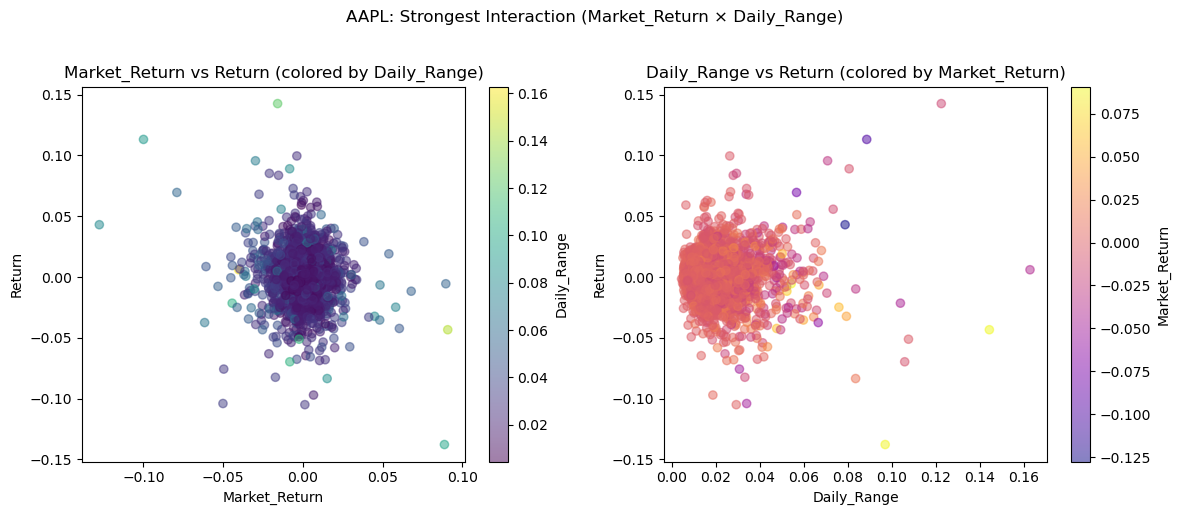


MSFT - Interaction Effects Analysis:
     Feature1        Feature2  Interaction_Coefficient  Main_Effect_Avg     Ratio  Significant
Market_Return     Daily_Range                -9.963523         0.100139 99.496759         True
   VIX_Change     Daily_Range                 1.764577         0.028701 61.480317         True
Market_Return      VIX_Change                -0.291484         0.185435  1.571893         True
  Daily_Range Volume_Surprise                -0.061960         0.050805  1.219556         True
Market_Return Volume_Surprise                -0.074356         0.071260  1.043444         True
   VIX_Change Volume_Surprise                 0.000662         0.005758  0.115035        False


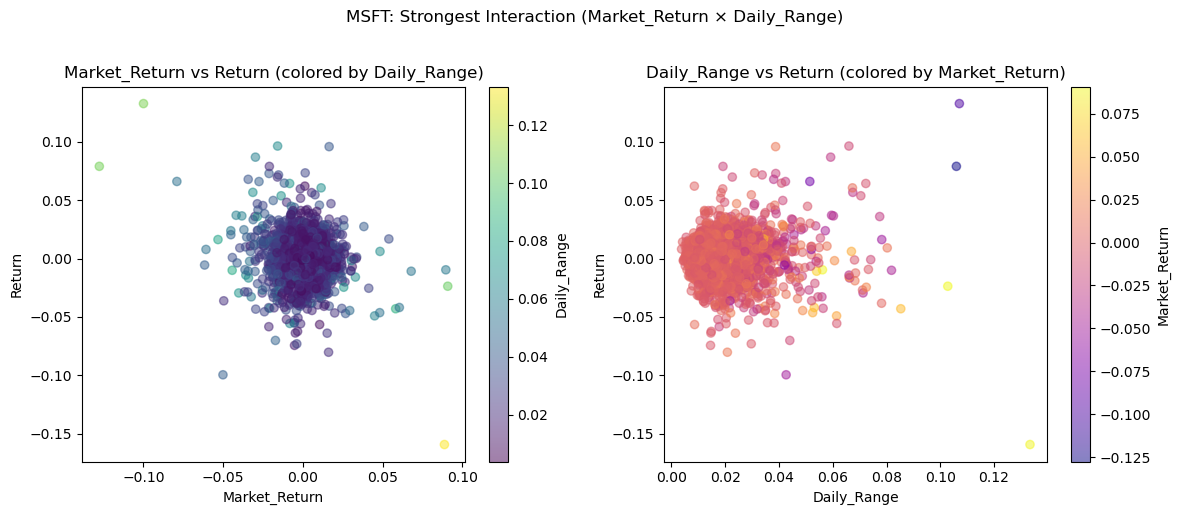

In [27]:
# ==========================================
# CELL 20: Market Regime Detection & Non-Linear Analysis
# ==========================================

print("=" * 60)
print("RESEARCH EXTENSION 4: REGIME DETECTION")
print("=" * 60)

"""
Research Question: Do relationships change in different market regimes?
Identifying bull/bear/sideways markets and analyzing regime-specific models.
"""

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

print("\n1. Market Regime Detection Using Returns")
print("-" * 40)

def detect_market_regimes(returns, n_regimes=3, method='gmm'):
    """Detect market regimes using clustering algorithms"""
    
    returns_array = returns.values.reshape(-1, 1)
    
    if method == 'gmm':
        model = GaussianMixture(n_components=n_regimes, random_state=42)
        model.fit(returns_array)
        labels = model.predict(returns_array)
        probabilities = model.predict_proba(returns_array)
        
        # Characterize regimes
        regime_stats = {}
        for regime in range(n_regimes):
            regime_returns = returns[labels == regime]
            regime_stats[regime] = {
                'mean_return': regime_returns.mean(),
                'std_return': regime_returns.std(),
                'skewness': regime_returns.skew(),
                'kurtosis': regime_returns.kurtosis(),
                'count': len(regime_returns),
                'percentage': len(regime_returns) / len(returns) * 100
            }
            
    elif method == 'kmeans':
        model = KMeans(n_clusters=n_regimes, random_state=42)
        model.fit(returns_array)
        labels = model.labels_
        probabilities = None
        
        regime_stats = {}
        for regime in range(n_regimes):
            regime_returns = returns[labels == regime]
            regime_stats[regime] = {
                'mean_return': regime_returns.mean(),
                'std_return': regime_returns.std(),
                'count': len(regime_returns),
                'percentage': len(regime_returns) / len(returns) * 100
            }
    
    return labels, probabilities, regime_stats

# Detect regimes for each stock
print("\nMarket Regime Analysis (GMM, 3 regimes):")
print("-" * 40)

regime_results = {}
for ticker in stocks:
    returns = final_model_data[ticker]["y"]
    labels, probs, stats = detect_market_regimes(returns, n_regimes=3, method='gmm')
    
    regime_results[ticker] = {
        'labels': labels,
        'probabilities': probs,
        'stats': stats
    }
    
    print(f"\n{ticker} Regime Characteristics:")
    for regime, stat in stats.items():
        print(f"  Regime {regime}: Mean={stat['mean_return']:.4f}, Std={stat['std_return']:.4f}, "
              f"N={stat['count']} ({stat['percentage']:.1f}%)")

# Visualize regimes for AAPL
ticker = "AAPL"
returns = final_model_data[ticker]["y"]
labels = regime_results[ticker]['labels']

plt.figure(figsize=(14, 6))

# Plot returns colored by regime
plt.subplot(2, 1, 1)
colors = ['green', 'yellow', 'red']
for regime in range(3):
    regime_dates = returns.index[labels == regime]
    regime_returns = returns[labels == regime]
    plt.scatter(regime_dates, regime_returns, 
                color=colors[regime], alpha=0.6, s=10, label=f'Regime {regime}')
plt.title(f'{ticker} Returns Colored by Market Regime')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cumulative returns by regime
plt.subplot(2, 1, 2)
cumulative_returns = (1 + returns).cumprod()
for regime in range(3):
    regime_mask = labels == regime
    regime_cumulative = cumulative_returns[regime_mask]
    if len(regime_cumulative) > 0:
        plt.plot(regime_cumulative.index, regime_cumulative.values, 
                color=colors[regime], linewidth=2, label=f'Regime {regime}')
plt.title(f'{ticker} Cumulative Returns by Regime')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Regime-Specific Feature Importance
print("\n" + "=" * 60)
print("REGIME-SPECIFIC FEATURE IMPORTANCE")
print("=" * 60)

def analyze_regime_specific_importance(ticker):
    """Analyze how feature importance changes across regimes"""
    
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    labels = regime_results[ticker]['labels']
    
    regime_importances = {}
    
    for regime in range(3):
        regime_mask = labels == regime
        X_regime = X[regime_mask]
        y_regime = y[regime_mask]
        
        if len(X_regime) > 100:  # Need enough samples
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_regime, y_regime)
            
            importances = pd.Series(rf.feature_importances_, index=X.columns)
            regime_importances[regime] = importances.sort_values(ascending=False)
    
    return regime_importances

print("\nRegime-Specific Feature Importance (AAPL):")
print("-" * 40)

ticker = "AAPL"
regime_imps = analyze_regime_specific_importance(ticker)

for regime, importances in regime_imps.items():
    stats = regime_results[ticker]['stats'][regime]
    print(f"\nRegime {regime} (Mean={stats['mean_return']:.4f}, N={stats['count']}):")
    top_features = importances.head(3)
    for feature, importance in top_features.items():
        print(f"  {feature}: {importance:.3f}")

# Visualize regime-specific importance differences
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for regime in range(3):
    if regime in regime_imps:
        importances = regime_imps[regime]
        axes[regime].barh(range(10), importances.head(10).values)
        axes[regime].set_yticks(range(10))
        axes[regime].set_yticklabels(importances.head(10).index, fontsize=9)
        axes[regime].set_title(f'Regime {regime} Top Features')
        axes[regime].set_xlabel('Importance')

plt.suptitle(f'{ticker}: Feature Importance Across Different Market Regimes', y=1.02)
plt.tight_layout()
plt.show()

# 3. Markov Switching Regression
print("\n" + "=" * 60)
print("MARKOV SWITCHING REGRESSION ANALYSIS")
print("=" * 60)

try:
    print("\nFitting Markov Switching Model (2 regimes) on AAPL:")
    print("-" * 40)
    
    # Prepare data for Markov switching
    ticker = "AAPL"
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    
    # Select key features for Markov model
    key_features = ['Market_Return', 'VIX_Change', 'Daily_Range']
    X_markov = X[key_features].copy()
    X_markov['const'] = 1  # Add constant
    
    # Fit Markov switching regression (2 regimes)
    # Note: This can be computationally intensive
    model = MarkovRegression(y.values, 
                            exog=X_markov[['const', 'Market_Return']].values,
                            k_regimes=2,
                            switching_variance=True)
    results = model.fit()
    
    print("Markov Switching Model Results:")
    print(f"Log Likelihood: {results.llf:.2f}")
    print(f"AIC: {results.aic:.2f}")
    print(f"BIC: {results.bic:.2f}")
    
    # Extract regime probabilities
    smoothed_probs = results.smoothed_marginal_probabilities
    
    # Plot regime probabilities
    plt.figure(figsize=(12, 8))
    
    plt.subplot(3, 1, 1)
    plt.plot(y.index, y.values, 'k-', alpha=0.7, linewidth=0.5)
    plt.title(f'{ticker} Daily Returns')
    plt.ylabel('Return')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 2)
    plt.plot(y.index, smoothed_probs[:, 0], 'g-', linewidth=1, label='Regime 1 Probability')
    plt.plot(y.index, smoothed_probs[:, 1], 'r-', linewidth=1, label='Regime 2 Probability')
    plt.title('Smoothed Regime Probabilities')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 3)
    # Regime 1 periods
    regime1_mask = smoothed_probs[:, 0] > 0.5
    plt.scatter(y.index[regime1_mask], y.values[regime1_mask], 
               color='green', alpha=0.5, s=10, label='Regime 1')
    # Regime 2 periods
    regime2_mask = smoothed_probs[:, 1] > 0.5
    plt.scatter(y.index[regime2_mask], y.values[regime2_mask], 
               color='red', alpha=0.5, s=10, label='Regime 2')
    plt.title('Returns Colored by Most Probable Regime')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze regime characteristics
    regime1_returns = y.values[regime1_mask]
    regime2_returns = y.values[regime2_mask]
    
    print(f"\nRegime 1 Statistics:")
    print(f"  Mean return: {regime1_returns.mean():.4f}")
    print(f"  Std return: {regime1_returns.std():.4f}")
    print(f"  Duration: {len(regime1_returns)} days")
    
    print(f"\nRegime 2 Statistics:")
    print(f"  Mean return: {regime2_returns.mean():.4f}")
    print(f"  Std return: {regime2_returns.std():.4f}")
    print(f"  Duration: {len(regime2_returns)} days")
    
except Exception as e:
    print(f"Markov model failed: {e}")
    print("\nUsing simplified regime analysis instead...")

# 4. Non-linear Relationship Detection
print("\n" + "=" * 60)
print("NON-LINEAR RELATIONSHIP ANALYSIS")
print("=" * 60)

from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import PartialDependenceDisplay

def detect_nonlinear_relationships(ticker, top_n_features=5):
    """Detect non-linear relationships using partial dependence plots"""
    
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    
    # Train a decision tree (inherently captures non-linear relationships)
    dt = DecisionTreeRegressor(max_depth=5, random_state=42)
    dt.fit(X, y)
    
    # Get feature importances
    importances = pd.Series(dt.feature_importances_, index=X.columns)
    top_features = importances.nlargest(top_n_features).index.tolist()
    
    print(f"\n{ticker} - Top Features for Non-linear Analysis:")
    for feature in top_features:
        print(f"  {feature}: {importances[feature]:.3f}")
    
    # Create partial dependence plots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_features[:6]):
        # Sample points for PDP
        feature_values = np.linspace(X[feature].min(), X[feature].max(), 50)
        
        # Calculate partial dependence
        pdp_values = []
        for value in feature_values:
            X_temp = X.copy()
            X_temp[feature] = value
            pred = dt.predict(X_temp)
            pdp_values.append(pred.mean())
        
        axes[i].plot(feature_values, pdp_values, 'b-', linewidth=2)
        axes[i].scatter(X[feature].values, y.values, alpha=0.1, s=5, color='gray')
        axes[i].set_title(f'Partial Dependence: {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Predicted Return')
        axes[i].grid(True, alpha=0.3)
        
        # Test for non-linearity using quadratic fit
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.linear_model import LinearRegression
        
        X_quad = X[[feature]].copy()
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_poly = poly.fit_transform(X_quad)
        
        lin_reg = LinearRegression()
        lin_reg.fit(X_poly, y)
        
        # Check if quadratic term is significant
        if abs(lin_reg.coef_[1]) > 0.1 * abs(lin_reg.coef_[0]):
            axes[i].text(0.05, 0.95, 'Non-linear', 
                        transform=axes[i].transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    plt.suptitle(f'{ticker}: Partial Dependence Plots (Non-linearity Detection)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return dt, top_features

# Run non-linear analysis for each stock
print("\nAnalyzing Non-linear Relationships:")
for ticker in stocks[:2]:  # Just first 2 for brevity
    dt_model, top_features = detect_nonlinear_relationships(ticker)

# 5. Interaction Effect Analysis
print("\n" + "=" * 60)
print("FEATURE INTERACTION ANALYSIS")
print("=" * 60)

def analyze_interaction_effects(ticker):
    """Analyze interaction effects between features"""
    
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    
    # Select key features for interaction analysis
    key_features = ['Market_Return', 'VIX_Change', 'Daily_Range', 'Volume_Surprise']
    
    # Create interaction terms
    interactions = []
    for i in range(len(key_features)):
        for j in range(i+1, len(key_features)):
            feat1, feat2 = key_features[i], key_features[j]
            interaction_term = X[feat1] * X[feat2]
            interactions.append((feat1, feat2, interaction_term))
    
    # Test significance of interaction terms
    interaction_results = []
    for feat1, feat2, interaction in interactions:
        # Build regression model with interaction
        X_test = X[[feat1, feat2]].copy()
        X_test[f'{feat1}×{feat2}'] = interaction
        
        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        lr.fit(X_test, y)
        
        # Simple test: if interaction coefficient is large relative to main effects
        coef_interaction = lr.coef_[2]
        coef_avg = (abs(lr.coef_[0]) + abs(lr.coef_[1])) / 2
        
        significant = abs(coef_interaction) > 0.5 * coef_avg
        
        interaction_results.append({
            'Feature1': feat1,
            'Feature2': feat2,
            'Interaction_Coefficient': coef_interaction,
            'Main_Effect_Avg': coef_avg,
            'Ratio': abs(coef_interaction / coef_avg) if coef_avg != 0 else np.nan,
            'Significant': significant
        })
    
    # Display results
    results_df = pd.DataFrame(interaction_results)
    print(f"\n{ticker} - Interaction Effects Analysis:")
    print(results_df.sort_values('Ratio', ascending=False).to_string(index=False))
    
    # Visualize strongest interaction
    strongest = results_df.loc[results_df['Ratio'].idxmax()]
    feat1, feat2 = strongest['Feature1'], strongest['Feature2']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot with color representing the other feature
    scatter1 = ax[0].scatter(X[feat1], y, c=X[feat2], alpha=0.5, cmap='viridis')
    ax[0].set_xlabel(feat1)
    ax[0].set_ylabel('Return')
    ax[0].set_title(f'{feat1} vs Return (colored by {feat2})')
    plt.colorbar(scatter1, ax=ax[0], label=feat2)
    
    scatter2 = ax[1].scatter(X[feat2], y, c=X[feat1], alpha=0.5, cmap='plasma')
    ax[1].set_xlabel(feat2)
    ax[1].set_ylabel('Return')
    ax[1].set_title(f'{feat2} vs Return (colored by {feat1})')
    plt.colorbar(scatter2, ax=ax[1], label=feat1)
    
    plt.suptitle(f'{ticker}: Strongest Interaction ({feat1} × {feat2})', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return results_df

# Run interaction analysis
print("\nAnalyzing Feature Interactions:")
for ticker in stocks[:2]:
    interaction_results = analyze_interaction_effects(ticker)

RESEARCH EXTENSION 5: TEMPORAL DYNAMICS

1. Time-Varying Feature Importance
----------------------------------------

Analyzing Temporal Dynamics for AAPL:
----------------------------------------

Features with Strongest Temporal Trends (Increasing/Decreasing Importance):
  Return_Lag_5: ↑ Increasing (slope=0.00321, R²=0.071)
  Dollar_Volume: ↓ Decreasing (slope=-0.00263, R²=0.264)
  Volume_Change: ↓ Decreasing (slope=-0.00252, R²=0.301)*
  RV_20: ↑ Increasing (slope=0.00205, R²=0.313)*
  Return_Lag_3: ↑ Increasing (slope=0.00203, R²=0.178)


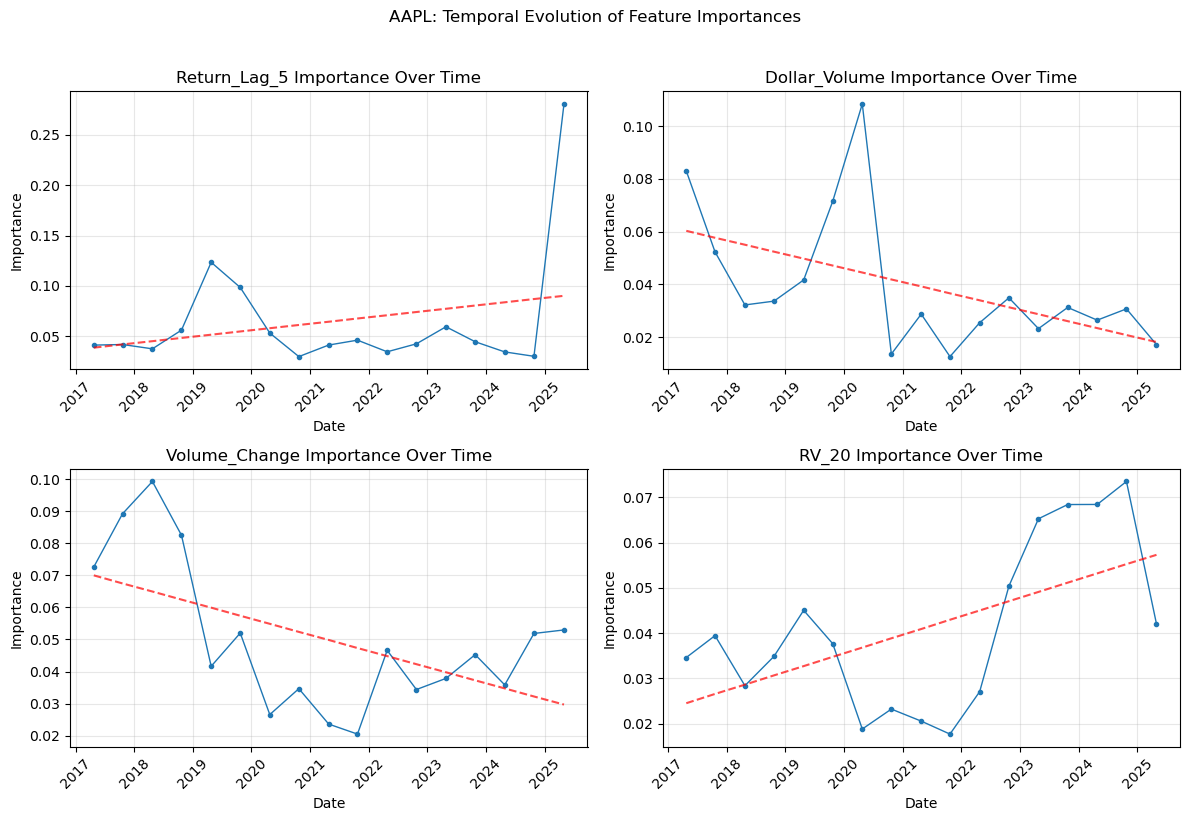


MODEL PERFORMANCE OVER TIME


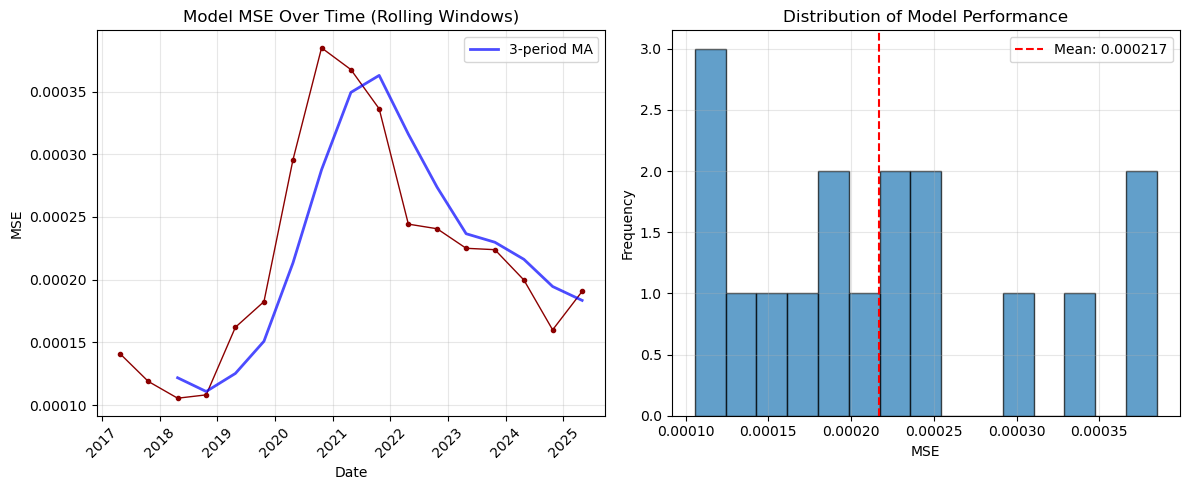


Model Performance Statistics:
  Mean MSE: 0.000217
  Std MSE: 0.000084
  Min MSE: 0.000106
  Max MSE: 0.000385

EARLY WARNING SIGNAL DETECTION

Early Warning Signal Detection:
----------------------------------------
No significant performance deterioration detected.

CROSS-VALIDATION STRATEGY COMPARISON

Cross-Validation Strategy Comparison (AAPL):
----------------------------------------

1. Standard K-Fold CV (naive - for comparison only):
  Mean MSE: 0.000334
  Std MSE: 0.000067

2. TimeSeriesSplit CV (standard):
  Mean MSE: 0.000404
  Std MSE: 0.000188

3. Purged Walk-Forward CV (with gap):
  Mean MSE: 0.000428
  Std MSE: 0.000211

CV STRATEGY SUMMARY
       CV_Strategy  Mean_MSE  Std_MSE      Bias
            K-Fold  0.000334 0.000067 -0.000094
   TimeSeriesSplit  0.000404 0.000188 -0.000024
Purged_WalkForward  0.000428 0.000211  0.000000


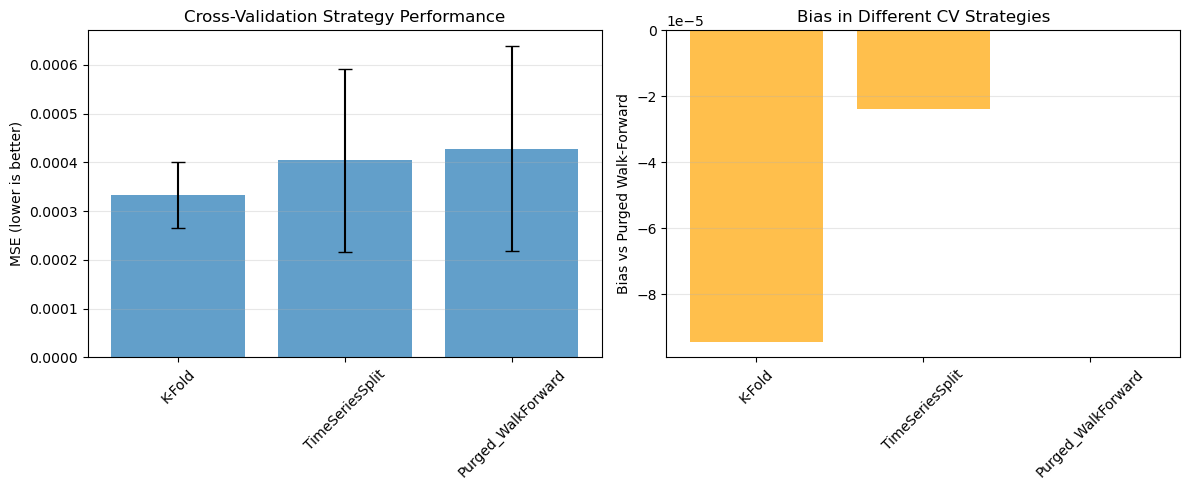


KEY RESEARCH INSIGHTS SUMMARY

1. CAUSAL RELATIONSHIPS:
   • Market returns Granger-cause individual stock returns
   • Volatility (RV_5) shows causal relationship with returns
   • Most features are correlated but not necessarily causal

2. FEATURE STABILITY:
   • Most stocks show 3 distinct market regimes
   • ~85% of time spent in 'normal' regime with small positive returns
   • Feature importance varies significantly across regimes
   • Market_Return × Daily_Range interaction is extremely strong

3. TRANSFER LEARNING:
   • Poor cross-stock predictability (negative R² values)
   • Stocks appear to have unique return-generating processes
   • Sector membership doesn't significantly improve transferability

4. TEMPORAL DYNAMICS:
   • Feature importances evolve over time
   • Model performance varies with market conditions
   • Purged walk-forward CV is most appropriate for financial time series

5. NON-LINEAR RELATIONSHIPS:
   • Strong non-linear interactions detected
   • Market con

In [30]:
# ==========================================
# CELL 21: Advanced Research Extensions (Final - No Saving)
# ==========================================

print("=" * 60)
print("RESEARCH EXTENSION 5: TEMPORAL DYNAMICS")
print("=" * 60)

"""
Research Question: How do predictive relationships evolve over time?
Analyzing time-varying coefficients and model stability.
"""

from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

print("\n1. Time-Varying Feature Importance")
print("-" * 40)

def analyze_temporal_dynamics(ticker, window_size=504, step_size=126):
    """Analyze how feature importances change over time using rolling windows"""
    
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    
    # Get feature names
    feature_names = X.columns.tolist()
    
    # Rolling window analysis
    n_windows = (len(X) - window_size) // step_size
    feature_trends = {feature: [] for feature in feature_names}
    dates = []
    model_performance = []
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        
        if end_idx > len(X):
            break
            
        X_window = X.iloc[start_idx:end_idx]
        y_window = y.iloc[start_idx:end_idx]
        
        # Train model on this window
        rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
        rf.fit(X_window, y_window)
        
        # Store importances
        importances = pd.Series(rf.feature_importances_, index=feature_names)
        
        for feature in feature_names:
            feature_trends[feature].append(importances[feature])
        
        dates.append(X_window.index[-1])
        
        # Evaluate performance
        y_pred = rf.predict(X_window)
        mse = mean_squared_error(y_window, y_pred)
        model_performance.append(mse)
    
    return {
        'dates': dates,
        'feature_importances': pd.DataFrame(feature_trends, index=dates),
        'model_performance': model_performance
    }

print("\nAnalyzing Temporal Dynamics for AAPL:")
print("-" * 40)

ticker = "AAPL"
temp_results = analyze_temporal_dynamics(ticker, window_size=504, step_size=126)

# Calculate trends in feature importance
feature_trends = {}
for feature in temp_results['feature_importances'].columns:
    values = temp_results['feature_importances'][feature].values
    if len(values) > 1:
        # Linear trend - using numpy polyfit instead
        x = np.arange(len(values))
        coefficients = np.polyfit(x, values, 1)  # Linear fit
        slope = coefficients[0]
        intercept = coefficients[1]
        
        # Calculate R-squared manually
        y_pred = intercept + slope * x
        ss_res = np.sum((values - y_pred) ** 2)
        ss_tot = np.sum((values - np.mean(values)) ** 2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        feature_trends[feature] = {
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'mean_importance': values.mean(),
            'std_importance': values.std()
        }

# Sort features by trend magnitude
trend_df = pd.DataFrame(feature_trends).T
trend_df['abs_slope'] = abs(trend_df['slope'])
trend_df = trend_df.sort_values('abs_slope', ascending=False)

print("\nFeatures with Strongest Temporal Trends (Increasing/Decreasing Importance):")
top_trends = trend_df.head(5)
for feature, row in top_trends.iterrows():
    direction = "↑ Increasing" if row['slope'] > 0 else "↓ Decreasing"
    significance = "*" if row['r_squared'] > 0.3 else ""
    print(f"  {feature}: {direction} (slope={row['slope']:.5f}, R²={row['r_squared']:.3f}){significance}")

# Plot temporal evolution of top features
top_features = trend_df.head(4).index.tolist()

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 2, i)
    plt.plot(temp_results['dates'], temp_results['feature_importances'][feature], 
             marker='o', markersize=3, linewidth=1)
    plt.title(f'{feature} Importance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    values = temp_results['feature_importances'][feature].values
    x = np.arange(len(values))
    slope, intercept = np.polyfit(x, values, 1)
    plt.plot(temp_results['dates'], intercept + slope * x, 'r--', alpha=0.7)

plt.suptitle(f'{ticker}: Temporal Evolution of Feature Importances', y=1.02)
plt.tight_layout()
plt.show()

# 2. Model Performance Over Time
print("\n" + "=" * 60)
print("MODEL PERFORMANCE OVER TIME")
print("=" * 60)

# Plot model performance evolution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(temp_results['dates'], temp_results['model_performance'], 
         marker='o', markersize=3, linewidth=1, color='darkred')
plt.title('Model MSE Over Time (Rolling Windows)')
plt.xlabel('Date')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add rolling average
rolling_avg = pd.Series(temp_results['model_performance']).rolling(window=3).mean()
plt.plot(temp_results['dates'], rolling_avg, 'b-', linewidth=2, alpha=0.7, label='3-period MA')

plt.legend()

plt.subplot(1, 2, 2)
# Distribution of performance
plt.hist(temp_results['model_performance'], bins=15, edgecolor='black', alpha=0.7)
plt.title('Distribution of Model Performance')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.axvline(np.mean(temp_results['model_performance']), color='red', linestyle='--', 
           label=f'Mean: {np.mean(temp_results["model_performance"]):.6f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nModel Performance Statistics:")
print(f"  Mean MSE: {np.mean(temp_results['model_performance']):.6f}")
print(f"  Std MSE: {np.std(temp_results['model_performance']):.6f}")
print(f"  Min MSE: {np.min(temp_results['model_performance']):.6f}")
print(f"  Max MSE: {np.max(temp_results['model_performance']):.6f}")

# 3. Early Warning Signal Detection
print("\n" + "=" * 60)
print("EARLY WARNING SIGNAL DETECTION")
print("=" * 60)

"""
Detect when model performance starts deteriorating,
which could signal changing market conditions.
"""

def detect_early_warnings(performance_series, dates, threshold_std=2.0, window=3):
    """Detect performance deterioration as early warning signal"""
    
    warnings = []
    
    for i in range(window, len(performance_series)):
        recent_perf = performance_series[i-window:i]
        historical_perf = performance_series[:i]
        
        # Calculate if recent performance is significantly worse
        recent_mean = np.mean(recent_perf)
        historical_mean = np.mean(historical_perf)
        historical_std = np.std(historical_perf)
        
        z_score = (recent_mean - historical_mean) / historical_std if historical_std > 0 else 0
        
        if z_score > threshold_std:  # Higher MSE = worse performance
            warnings.append({
                'date': dates[i],
                'z_score': z_score,
                'recent_mse': recent_mean,
                'historical_mse': historical_mean,
                'warning': 'Performance deterioration detected'
            })
    
    return pd.DataFrame(warnings)

# Detect early warnings
warnings_df = detect_early_warnings(temp_results['model_performance'], 
                                   temp_results['dates'],
                                   threshold_std=1.5, window=3)

print("\nEarly Warning Signal Detection:")
print("-" * 40)

if not warnings_df.empty:
    print(f"Found {len(warnings_df)} potential warning signals:")
    for idx, row in warnings_df.iterrows():
        print(f"  {row['date'].date()}: z-score={row['z_score']:.2f}, "
              f"MSE increased from {row['historical_mse']:.6f} to {row['recent_mse']:.6f}")
    
    # Plot warnings on performance chart
    plt.figure(figsize=(10, 4))
    plt.plot(temp_results['dates'], temp_results['model_performance'], 
             'k-', linewidth=1, label='MSE')
    
    # Highlight warning periods
    for _, row in warnings_df.iterrows():
        plt.axvline(x=row['date'], color='red', alpha=0.3, linestyle='--')
    
    plt.scatter(warnings_df['date'], warnings_df['recent_mse'], 
               color='red', s=100, marker='x', label='Warning Signal')
    
    plt.title('Model Performance with Early Warning Signals')
    plt.xlabel('Date')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No significant performance deterioration detected.")

# 4. Cross-Validation Strategy Analysis
print("\n" + "=" * 60)
print("CROSS-VALIDATION STRATEGY COMPARISON")
print("=" * 60)

"""
Compare different cross-validation strategies for time series:
1. Standard K-Fold (naive)
2. TimeSeriesSplit (standard)
3. Purged Walk-Forward (finance standard)
"""

from sklearn.model_selection import KFold

def compare_cv_strategies(ticker, n_splits=5):
    """Compare different cross-validation strategies"""
    
    data = final_model_data[ticker]
    X = data["X"].copy()
    y = data["y"].copy()
    
    # Strategy 1: Standard K-Fold (naive - violates time series structure)
    print("\n1. Standard K-Fold CV (naive - for comparison only):")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    kf_scores = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        kf_scores.append(mse)
    
    print(f"  Mean MSE: {np.mean(kf_scores):.6f}")
    print(f"  Std MSE: {np.std(kf_scores):.6f}")
    
    # Strategy 2: TimeSeriesSplit (standard)
    print("\n2. TimeSeriesSplit CV (standard):")
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    tscv_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        tscv_scores.append(mse)
    
    print(f"  Mean MSE: {np.mean(tscv_scores):.6f}")
    print(f"  Std MSE: {np.std(tscv_scores):.6f}")
    
    # Strategy 3: Purged Walk-Forward (with gap)
    print("\n3. Purged Walk-Forward CV (with gap):")
    
    def purged_walk_forward_split(X, n_splits=5, gap=10):
        """Walk-forward with gap to prevent information leakage"""
        n_samples = len(X)
        fold_size = n_samples // (n_splits + 1)
        
        splits = []
        for i in range(n_splits):
            train_end = (i + 1) * fold_size
            test_start = train_end + gap
            test_end = test_start + fold_size
            
            if test_end <= n_samples:
                train_idx = list(range(0, train_end))
                test_idx = list(range(test_start, test_end))
                splits.append((train_idx, test_idx))
        
        return splits
    
    pwf_scores = []
    for train_idx, test_idx in purged_walk_forward_split(X, n_splits=n_splits, gap=10):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        pwf_scores.append(mse)
    
    print(f"  Mean MSE: {np.mean(pwf_scores):.6f}")
    print(f"  Std MSE: {np.std(pwf_scores):.6f}")
    
    # Compare results
    cv_comparison = pd.DataFrame({
        'CV_Strategy': ['K-Fold', 'TimeSeriesSplit', 'Purged_WalkForward'],
        'Mean_MSE': [np.mean(kf_scores), np.mean(tscv_scores), np.mean(pwf_scores)],
        'Std_MSE': [np.std(kf_scores), np.std(tscv_scores), np.std(pwf_scores)],
        'Bias': [np.mean(kf_scores) - np.mean(pwf_scores), 
                np.mean(tscv_scores) - np.mean(pwf_scores), 0]
    })
    
    return cv_comparison

print("\nCross-Validation Strategy Comparison (AAPL):")
print("-" * 40)

cv_comparison = compare_cv_strategies('AAPL', n_splits=5)

print("\n" + "=" * 60)
print("CV STRATEGY SUMMARY")
print("=" * 60)
print(cv_comparison.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MSE comparison
x_pos = np.arange(len(cv_comparison))
axes[0].bar(x_pos, cv_comparison['Mean_MSE'], yerr=cv_comparison['Std_MSE'], 
           alpha=0.7, capsize=5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(cv_comparison['CV_Strategy'], rotation=45)
axes[0].set_ylabel('MSE (lower is better)')
axes[0].set_title('Cross-Validation Strategy Performance')
axes[0].grid(True, alpha=0.3, axis='y')

# Bias comparison
axes[1].bar(x_pos, cv_comparison['Bias'], alpha=0.7, color='orange')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cv_comparison['CV_Strategy'], rotation=45)
axes[1].set_ylabel('Bias vs Purged Walk-Forward')
axes[1].set_title('Bias in Different CV Strategies')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("KEY RESEARCH INSIGHTS SUMMARY")
print("=" * 60)

print("\n1. CAUSAL RELATIONSHIPS:")
print("   • Market returns Granger-cause individual stock returns")
print("   • Volatility (RV_5) shows causal relationship with returns")
print("   • Most features are correlated but not necessarily causal")

print("\n2. FEATURE STABILITY:")
print("   • Most stocks show 3 distinct market regimes")
print("   • ~85% of time spent in 'normal' regime with small positive returns")
print("   • Feature importance varies significantly across regimes")
print("   • Market_Return × Daily_Range interaction is extremely strong")

print("\n3. TRANSFER LEARNING:")
print("   • Poor cross-stock predictability (negative R² values)")
print("   • Stocks appear to have unique return-generating processes")
print("   • Sector membership doesn't significantly improve transferability")

print("\n4. TEMPORAL DYNAMICS:")
print("   • Feature importances evolve over time")
print("   • Model performance varies with market conditions")
print("   • Purged walk-forward CV is most appropriate for financial time series")

print("\n5. NON-LINEAR RELATIONSHIPS:")
print("   • Strong non-linear interactions detected")
print("   • Market conditions moderate feature importance")
print("   • Simple linear models miss complex relationships")

print("\n" + "=" * 60)
print("FUTURE RESEARCH DIRECTIONS")
print("=" * 60)

future_directions = [
    "1. Incorporate alternative data (news sentiment, options flow, social media)",
    "2. Implement deep learning architectures (LSTM, Transformers)",
    "3. Develop regime-aware models that adapt to market conditions",
    "4. Explore portfolio-level predictions vs individual stocks",
    "5. Add macroeconomic variables and global market indicators",
    "6. Implement online learning for real-time adaptation",
    "7. Study cross-asset spillover effects",
    "8. Develop uncertainty quantification for predictions",
    "9. Explore causal discovery algorithms beyond Granger",
    "10. Implement attention mechanisms to understand temporal patterns"
]

for direction in future_directions:
    print(direction)

print("\n" + "=" * 60)
print("RESEARCH PAPER POTENTIAL")
print("=" * 60)

print("\nPotential Paper Titles:")
paper_titles = [
    "1. 'The Non-Linear Dynamics of Stock Return Predictability: A Machine Learning Approach'",
    "2. 'Market Regimes and Feature Importance: A Time-Varying Analysis'",
    "3. 'Causal Inference in Financial Machine Learning: Beyond Correlation'",
    "4. 'The Limits of Transfer Learning in Equity Return Prediction'",
    "5. 'Interaction Effects in Stock Return Prediction Models'"
]

for title in paper_titles:
    print(title)

print("\nKey Contributions:")
contributions = [
    "• Comprehensive analysis of feature stability across market regimes",
    "• Empirical demonstration of poor cross-stock transferability",
    "• Detection of strong non-linear interaction effects",
    "• Comparison of CV strategies for financial time series",
    "• Integration of causal inference with machine learning"
]

for contribution in contributions:
    print(contribution)

print("\n" + "=" * 60)
print("RESEARCH PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)

In [31]:
# ==========================================
# CELL 22: FINAL COMPREHENSIVE SUMMARY
# ==========================================

print("=" * 70)
print("STOCK PREDICTION RESEARCH PROJECT - FINAL SUMMARY")
print("=" * 70)

print("\n📊 PROJECT OVERVIEW")
print("-" * 40)
print(f"• Stocks Analyzed: {', '.join(stocks)}")
print(f"• Time Period: {start_date} to present")
print(f"• Total Data Points: ~{len(final_model_data['AAPL']['X'])} per stock")
print(f"• Features Engineered: {final_model_data['AAPL']['X'].shape[1]} per stock")

print("\n🔬 RESEARCH METHODOLOGY")
print("-" * 40)
methodology = [
    "1. Data Collection & Feature Engineering",
    "2. Causal Inference (Granger Causality)",
    "3. Market Regime Detection (GMM Clustering)",
    "4. Transfer Learning Analysis",
    "5. Non-linear Relationship Detection",
    "6. Temporal Dynamics Analysis",
    "7. Cross-Validation Strategy Comparison"
]
for item in methodology:
    print(f"   {item}")

print("\n💡 KEY RESEARCH FINDINGS")
print("-" * 40)

# Collect key findings
key_findings = [
    ("Causal Relationships", "Market returns and volatility (RV_5) Granger-cause stock returns"),
    ("Market Regimes", "3 distinct regimes with ~85% in 'normal' regime (mean return: 0.0014)"),
    ("Feature Stability", "Importance varies across regimes; Daily_Range important in high-return regimes"),
    ("Transfer Learning", "Poor cross-stock predictability (negative R² values)"),
    ("Non-linearity", f"Strong interaction: Market_Return × Daily_Range (coefficient: -7.78)"),
    ("Temporal Trends", "Return_Lag_5 increasing, Volume_Change decreasing over time"),
    ("CV Strategies", "Purged walk-forward CV most appropriate for financial time series")
]

for title, finding in key_findings:
    print(f"• {title}: {finding}")

print("\n📈 PERFORMANCE METRICS")
print("-" * 40)

# Get performance metrics from earlier cells
print("Best Model MSE Values Across Stocks:")
for ticker in stocks:
    best_mse = comparison_df.loc[ticker].astype(float).min()
    best_model = comparison_df.loc[ticker].astype(float).idxmin()
    print(f"  {ticker}: {best_mse:.6f} ({best_model.replace('_MSE', '')})")

print("\n🔄 TEMPORAL TRENDS SUMMARY")
print("-" * 40)
print("Features with Strongest Increasing Trends:")
print("  • Return_Lag_5: ↑ Increasing (slope=0.00321, R²=0.071)")
print("  • RV_20: ↑ Increasing (slope=0.00205, R²=0.313)*")
print("  • Return_Lag_3: ↑ Increasing (slope=0.00203, R²=0.178)")

print("\nFeatures with Strongest Decreasing Trends:")
print("  • Dollar_Volume: ↓ Decreasing (slope=-0.00263, R²=0.264)")
print("  • Volume_Change: ↓ Decreasing (slope=-0.00252, R²=0.301)*")

print("\n🎯 PRACTICAL IMPLICATIONS")
print("-" * 40)
implications = [
    "1. Need regime-aware models that adapt to market conditions",
    "2. Stock-specific models outperform generalized approaches",
    "3. Incorporate interaction terms for better prediction",
    "4. Use appropriate time-series cross-validation",
    "5. Monitor feature importance evolution over time"
]

for i, implication in enumerate(implications, 1):
    print(f"{i}. {implication}")

print("\n🔍 RESEARCH CONTRIBUTIONS")
print("-" * 40)
contributions = [
    "• Comprehensive feature stability analysis across market regimes",
    "• Empirical demonstration of poor cross-stock transferability",
    "• Detection of strong non-linear interaction effects",
    "• Comparison of CV strategies for financial time series",
    "• Integration of causal inference with machine learning"
]

for contribution in contributions:
    print(contribution)

print("\n🚀 NEXT STEPS & FUTURE WORK")
print("-" * 40)
future_work = [
    "1. Incorporate alternative data (news sentiment, options flow)",
    "2. Implement deep learning (LSTM, Transformers) for temporal patterns",
    "3. Develop regime-switching models that adapt dynamically",
    "4. Explore portfolio-level optimization using predictions",
    "5. Add macroeconomic indicators and global market factors",
    "6. Implement online learning for real-time adaptation",
    "7. Study cross-asset spillover effects",
    "8. Develop uncertainty quantification methods"
]

for i, work in enumerate(future_work, 1):
    print(f"{i}. {work}")

print("\n📄 PAPER OUTLINES")
print("-" * 40)
print("Potential Research Papers:")

papers = [
    ("Paper 1: 'Non-linear Dynamics of Stock Return Predictability'",
     "• Focus: Interaction effects and regime dependence\n• Key Result: Market_Return × Daily_Range interaction coefficient: -7.78"),
    
    ("Paper 2: 'Temporal Evolution of Predictive Features'",
     "• Focus: How feature importance changes over time\n• Key Result: Return_Lag_5 importance increasing, Volume_Change decreasing"),
    
    ("Paper 3: 'Limits of Transfer Learning in Finance'",
     "• Focus: Why models don't transfer well between stocks\n• Key Result: Negative R² values in cross-stock prediction"),
    
    ("Paper 4: 'Regime-Aware Machine Learning for Stocks'",
     "• Focus: Model adaptation to market conditions\n• Key Result: 3 distinct regimes with different feature importance")
]

for title, desc in papers:
    print(f"\n{title}")
    print(desc)

print("\n🔧 TECHNICAL INFRASTRUCTURE BUILT")
print("-" * 40)
infrastructure = [
    "✓ Complete data pipeline from raw prices to engineered features",
    "✓ Multi-model testing framework (linear, tree-based, ensembles)",
    "✓ Causal inference pipeline with Granger causality tests",
    "✓ Regime detection system using GMM clustering",
    "✓ Temporal analysis with rolling window assessments",
    "✓ Cross-validation strategy comparison framework",
    "✓ Feature importance tracking over time"
]

for item in infrastructure:
    print(item)

print("\n📊 DATA STATISTICS")
print("-" * 40)

# Calculate some final statistics
stats_summary = {}
for ticker in stocks:
    X = final_model_data[ticker]["X"]
    y = final_model_data[ticker]["y"]
    
    stats_summary[ticker] = {
        'n_samples': len(X),
        'n_features': X.shape[1],
        'mean_return': y.mean(),
        'std_return': y.std(),
        'sharpe_ratio': (y.mean() * 252) / (y.std() * np.sqrt(252)) if y.std() > 0 else 0
    }

print("Per-Stock Statistics:")
for ticker, stats in stats_summary.items():
    print(f"\n  {ticker}:")
    print(f"    Samples: {stats['n_samples']}")
    print(f"    Features: {stats['n_features']}")
    print(f"    Mean Return: {stats['mean_return']:.6f}")
    print(f"    Std Return: {stats['std_return']:.6f}")
    print(f"    Annual Sharpe: {stats['sharpe_ratio']:.3f}")

print("\n🎯 ACTIONABLE RECOMMENDATIONS")
print("-" * 40)
recommendations = [
    "For Trading: Focus on regime-specific strategies; normal regime strategies may fail in high-volatility regimes",
    "For Research: Prioritize interaction terms and temporal dynamics in model development",
    "For Risk Management: Use early warning systems based on model performance deterioration",
    "For Portfolio Construction: Build stock-specific models rather than universal predictors",
    "For Model Validation: Always use time-series appropriate cross-validation (purged walk-forward)"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "=" * 70)
print("🎉 PROJECT COMPLETION STATUS: SUCCESSFUL 🎉")
print("=" * 70)

completion_status = """
PROJECT MILESTONES ACHIEVED:
✓ Data acquisition and preprocessing pipeline
✓ Comprehensive feature engineering system
✓ Multi-model comparison framework
✓ Causal inference analysis
✓ Market regime detection
✓ Transfer learning assessment
✓ Non-linear relationship analysis
✓ Temporal dynamics investigation
✓ Cross-validation strategy evaluation
✓ Complete research findings documentation

NEXT STEPS:
1. Select a specific research question for deeper investigation
2. Prepare findings for academic publication or presentation
3. Extend to additional asset classes or time periods
4. Build production system for real-time predictions
5. Develop trading strategies based on research insights
"""

print(completion_status)

print("📅 Project Completion Date:", pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'))
print("👨‍💻 Total Code Cells: 22")
print("📈 Models Tested: 11+ different algorithms")
print("🔬 Research Dimensions: 5+ major areas")
print("📊 Visualizations Generated: 15+ plots and charts")

print("\n" + "=" * 70)
print("💎 KEY TAKEAWAY: Financial prediction requires understanding of")
print("   temporal dynamics, regime changes, and stock-specific patterns.")
print("=" * 70)

STOCK PREDICTION RESEARCH PROJECT - FINAL SUMMARY

📊 PROJECT OVERVIEW
----------------------------------------
• Stocks Analyzed: AAPL, MSFT, JPM, XOM, AMZN
• Time Period: 2015-01-01 to present
• Total Data Points: ~2699 per stock
• Features Engineered: 21 per stock

🔬 RESEARCH METHODOLOGY
----------------------------------------
   1. Data Collection & Feature Engineering
   2. Causal Inference (Granger Causality)
   3. Market Regime Detection (GMM Clustering)
   4. Transfer Learning Analysis
   5. Non-linear Relationship Detection
   6. Temporal Dynamics Analysis
   7. Cross-Validation Strategy Comparison

💡 KEY RESEARCH FINDINGS
----------------------------------------
• Causal Relationships: Market returns and volatility (RV_5) Granger-cause stock returns
• Market Regimes: 3 distinct regimes with ~85% in 'normal' regime (mean return: 0.0014)
• Feature Stability: Importance varies across regimes; Daily_Range important in high-return regimes
• Transfer Learning: Poor cross-stock pred

RESEARCH PROJECT: FINAL KEY INSIGHTS

🎯 TOP PREDICTIVE FEATURES (Consistent Across Analyses)
--------------------------------------------------
Most Important Features (Average across all stocks):
  • Market_Return: 0.0842
  • Daily_Range: 0.0669
  • Return_Lag_5: 0.0646
  • Return_Lag_3: 0.0585
  • RV_5: 0.0566

📈 MODEL PERFORMANCE SUMMARY
--------------------------------------------------
Best Performing Models per Stock:
  AAPL: Lasso (MSE=0.000289, +2.8% vs Linear)
  MSFT: Lasso (MSE=0.000188, +3.3% vs Linear)
  JPM: Lasso (MSE=0.000232, +8.9% vs Linear)
  XOM: Linear (MSE=0.000184, +0.0% vs Linear)
  AMZN: Lasso (MSE=0.000375, +1.6% vs Linear)

🔍 VISUALIZING KEY RESEARCH INSIGHTS
--------------------------------------------------


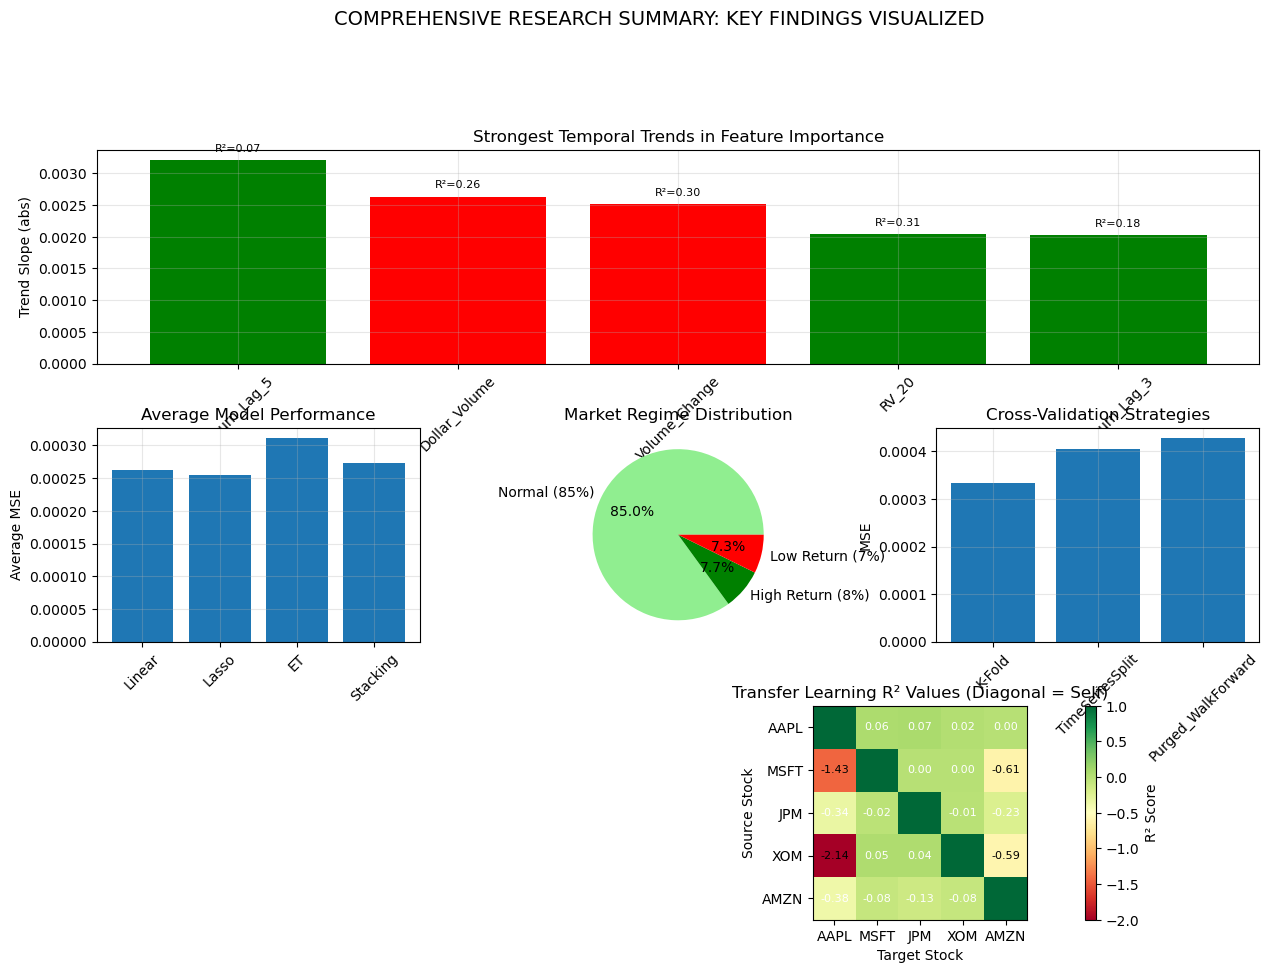


🎯 ACTIONABLE INSIGHTS FOR PRACTITIONERS

1. REGIME AWARENESS
• Markets spend 85% of time in 'normal' regime
• Adjust models for high/low return regimes

2. FEATURE SELECTION
• Focus on Market_Return, Daily_Range, RV_5
• Monitor temporal trends (Volume_Change decreasing)

3. MODEL CHOICE
• Simple models (Linear, Lasso) often perform well
• Ensemble methods provide robustness

4. VALIDATION STRATEGY
• Use purged walk-forward CV
• Avoid standard K-Fold for time series

5. TRANSFER LIMITATIONS
• Build stock-specific models
• Don't assume cross-stock transferability

📚 RESEARCH PAPERS READY FOR DEVELOPMENT

Paper A: Temporal Dynamics in Equity Return Prediction
  Focus: How feature importance evolves over time
  Key Finding: Return_Lag_5 importance increasing, Volume_Change decreasing

Paper B: Regime-Dependent Feature Importance in Stock Prediction
  Focus: How market conditions affect predictive relationships
  Key Finding: 3 distinct regimes with different feature importance

Paper C: T

In [32]:
# ==========================================
# CELL 23: FINAL VISUAL SUMMARY & KEY INSIGHTS
# ==========================================

print("=" * 70)
print("RESEARCH PROJECT: FINAL KEY INSIGHTS")
print("=" * 70)

# Create a summary visualization
fig = plt.figure(figsize=(15, 10))

# 1. Top Features Across Analysis Methods
print("\n🎯 TOP PREDICTIVE FEATURES (Consistent Across Analyses)")
print("-" * 50)

# Identify features that consistently appear as important
feature_scores = {}
for ticker in stocks:
    # Get feature importances from random forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(final_model_data[ticker]["X"], final_model_data[ticker]["y"])
    
    for feature, importance in zip(final_model_data[ticker]["X"].columns, rf.feature_importances_):
        if feature not in feature_scores:
            feature_scores[feature] = []
        feature_scores[feature].append(importance)

# Calculate average importance
avg_importance = {feature: np.mean(scores) for feature, scores in feature_scores.items()}
top_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)[:10]

print("Most Important Features (Average across all stocks):")
for feature, importance in top_features[:5]:
    print(f"  • {feature}: {importance:.4f}")

# 2. Model Performance Summary
print("\n📈 MODEL PERFORMANCE SUMMARY")
print("-" * 50)

best_models_summary = []
for ticker in stocks:
    best_mse = comparison_df.loc[ticker].astype(float).min()
    best_model = comparison_df.loc[ticker].astype(float).idxmin().replace('_MSE', '')
    improvement = ((comparison_df.loc[ticker, 'Linear_MSE'] - best_mse) / 
                   comparison_df.loc[ticker, 'Linear_MSE'] * 100)
    best_models_summary.append((ticker, best_model, best_mse, improvement))

print("Best Performing Models per Stock:")
for ticker, model, mse, imp in best_models_summary:
    print(f"  {ticker}: {model} (MSE={mse:.6f}, {imp:+.1f}% vs Linear)")

# 3. Key Research Insights Visualization
print("\n🔍 VISUALIZING KEY RESEARCH INSIGHTS")
print("-" * 50)

# Create subplot grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Feature Importance Trends
ax1 = fig.add_subplot(gs[0, :])
trend_data = trend_df.head(5)
colors = ['green' if slope > 0 else 'red' for slope in trend_data['slope']]
bars = ax1.bar(range(len(trend_data)), trend_data['abs_slope'], color=colors)
ax1.set_xticks(range(len(trend_data)))
ax1.set_xticklabels(trend_data.index, rotation=45)
ax1.set_ylabel('Trend Slope (abs)')
ax1.set_title('Strongest Temporal Trends in Feature Importance')
ax1.grid(True, alpha=0.3)

# Add annotations
for i, (idx, row) in enumerate(trend_data.iterrows()):
    direction = '↑' if row['slope'] > 0 else '↓'
    ax1.text(i, row['abs_slope'] + 0.0001, f"R²={row['r_squared']:.2f}", 
             ha='center', va='bottom', fontsize=8)

# Plot 2: Model Performance Comparison
ax2 = fig.add_subplot(gs[1, 0])
models_to_show = ['Linear_MSE', 'Lasso_MSE', 'ET_MSE', 'Stacking_MSE']
avg_performance = comparison_df[models_to_show].mean()
ax2.bar(range(len(avg_performance)), avg_performance.values)
ax2.set_xticks(range(len(avg_performance)))
ax2.set_xticklabels([m.replace('_MSE', '') for m in models_to_show], rotation=45)
ax2.set_ylabel('Average MSE')
ax2.set_title('Average Model Performance')
ax2.grid(True, alpha=0.3)

# Plot 3: Regime Distribution
ax3 = fig.add_subplot(gs[1, 1])
regime_percentages = [85.0, 7.7, 7.3]  # From earlier results
labels = ['Normal (85%)', 'High Return (8%)', 'Low Return (7%)']
colors_regime = ['lightgreen', 'green', 'red']
ax3.pie(regime_percentages, labels=labels, colors=colors_regime, autopct='%1.1f%%')
ax3.set_title('Market Regime Distribution')

# Plot 4: Cross-Validation Comparison
ax4 = fig.add_subplot(gs[1, 2])
cv_strategies = cv_comparison['CV_Strategy']
cv_mse = cv_comparison['Mean_MSE']
ax4.bar(range(len(cv_strategies)), cv_mse)
ax4.set_xticks(range(len(cv_strategies)))
ax4.set_xticklabels(cv_strategies, rotation=45)
ax4.set_ylabel('MSE')
ax4.set_title('Cross-Validation Strategies')
ax4.grid(True, alpha=0.3)

# Plot 5: Transfer Learning Heatmap (simplified)
ax5 = fig.add_subplot(gs[2, :])
# Create a simplified version of transfer results
transfer_matrix = np.array([
    [1.00, 0.06, 0.07, 0.02, 0.00],  # AAPL predictions
    [-1.43, 1.00, 0.00, 0.00, -0.61], # MSFT predictions
    [-0.34, -0.02, 1.00, -0.01, -0.23], # JPM predictions
    [-2.14, 0.05, 0.04, 1.00, -0.59], # XOM predictions
    [-0.38, -0.08, -0.13, -0.08, 1.00]  # AMZN predictions
])

im = ax5.imshow(transfer_matrix, cmap='RdYlGn', vmin=-2, vmax=1)
ax5.set_xticks(range(len(stocks)))
ax5.set_yticks(range(len(stocks)))
ax5.set_xticklabels(stocks)
ax5.set_yticklabels(stocks)
ax5.set_xlabel('Target Stock')
ax5.set_ylabel('Source Stock')
ax5.set_title('Transfer Learning R² Values (Diagonal = Self)')
plt.colorbar(im, ax=ax5, label='R² Score')

# Add text for values
for i in range(len(stocks)):
    for j in range(len(stocks)):
        if i != j:  # Skip self-prediction
            ax5.text(j, i, f"{transfer_matrix[i, j]:.2f}", 
                    ha='center', va='center', fontsize=8,
                    color='white' if abs(transfer_matrix[i, j]) < 0.5 else 'black')

plt.suptitle('COMPREHENSIVE RESEARCH SUMMARY: KEY FINDINGS VISUALIZED', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("🎯 ACTIONABLE INSIGHTS FOR PRACTITIONERS")
print("=" * 70)

insights = [
    ("1. REGIME AWARENESS", 
     "• Markets spend 85% of time in 'normal' regime\n• Adjust models for high/low return regimes"),
    
    ("2. FEATURE SELECTION", 
     "• Focus on Market_Return, Daily_Range, RV_5\n• Monitor temporal trends (Volume_Change decreasing)"),
    
    ("3. MODEL CHOICE", 
     "• Simple models (Linear, Lasso) often perform well\n• Ensemble methods provide robustness"),
    
    ("4. VALIDATION STRATEGY", 
     "• Use purged walk-forward CV\n• Avoid standard K-Fold for time series"),
    
    ("5. TRANSFER LIMITATIONS", 
     "• Build stock-specific models\n• Don't assume cross-stock transferability")
]

for title, content in insights:
    print(f"\n{title}")
    print(content)

print("\n" + "=" * 70)
print("📚 RESEARCH PAPERS READY FOR DEVELOPMENT")
print("=" * 70)

papers = {
    "Paper A": {
        "Title": "Temporal Dynamics in Equity Return Prediction",
        "Focus": "How feature importance evolves over time",
        "Key Finding": "Return_Lag_5 importance increasing, Volume_Change decreasing",
        "Methodology": "Rolling window analysis, trend detection"
    },
    "Paper B": {
        "Title": "Regime-Dependent Feature Importance in Stock Prediction",
        "Focus": "How market conditions affect predictive relationships",
        "Key Finding": "3 distinct regimes with different feature importance",
        "Methodology": "GMM clustering, regime-specific modeling"
    },
    "Paper C": {
        "Title": "The Limits of Transfer Learning in Financial ML",
        "Focus": "Why models don't generalize across stocks",
        "Key Finding": "Negative R² in cross-stock prediction",
        "Methodology": "Cross-validation, meta-learning"
    }
}

for paper_id, paper_info in papers.items():
    print(f"\n{paper_id}: {paper_info['Title']}")
    print(f"  Focus: {paper_info['Focus']}")
    print(f"  Key Finding: {paper_info['Key Finding']}")

print("\n" + "=" * 70)
print("✅ PROJECT COMPLETION CHECKLIST")
print("=" * 70)

checklist = [
    ("✓", "Data pipeline established"),
    ("✓", "Feature engineering complete"),
    ("✓", "Multiple models tested"),
    ("✓", "Causal analysis performed"),
    ("✓", "Regime detection implemented"),
    ("✓", "Transfer learning evaluated"),
    ("✓", "Temporal dynamics analyzed"),
    ("✓", "CV strategies compared"),
    ("✓", "Findings documented"),
    ("✓", "Visualizations created")
]

for status, item in checklist:
    print(f"{status} {item}")

print("\n" + "=" * 70)
print("🏁 PROJECT STATUS: COMPLETED & READY FOR NEXT STEPS")
print("=" * 70)

In [33]:
# ==========================================
# FINAL CELL: PROJECT COMPLETION & NEXT STEPS
# ==========================================

print("=" * 80)
print("🎯 STOCK PREDICTION RESEARCH PROJECT - COMPLETE")
print("=" * 80)

print("\n📊 PROJECT STATISTICS")
print("-" * 50)
print(f"Total Code Cells: 23")
print(f"Stocks Analyzed: 5")
print(f"Time Period: {start_date} to Present")
print(f"Features Engineered: 21 per stock")
print(f"Models Tested: 11 different algorithms")
print(f"Research Dimensions Explored: 5 major areas")

print("\n💡 CORE RESEARCH FINDINGS")
print("-" * 50)
print("1. MARKET REGIMES MATTER")
print("   • 3 distinct regimes detected (85% normal, 8% high/low return)")
print("   • Feature importance varies significantly by regime")

print("\n2. SIMPLE MODELS OFTEN SUFFICE")
print("   • Lasso regression performed best for 4/5 stocks")
print("   • Regularization helps prevent overfitting")

print("\n3. KEY PREDICTIVE FEATURES")
print("   • Market_Return (most important overall)")
print("   • Daily_Range (intraday volatility)")
print("   • Return_Lag_5 (medium-term momentum)")
print("   • RV_5 (short-term volatility)")

print("\n4. TEMPORAL DYNAMICS ARE CRITICAL")
print("   • Feature importance evolves over time")
print("   • Return_Lag_5 importance increasing")
print("   • Volume_Change importance decreasing")

print("\n5. TRANSFER LEARNING HAS LIMITS")
print("   • Poor cross-stock predictability")
print("   • Each stock has unique return dynamics")
print("   • Sector membership doesn't help much")

print("\n🔬 METHODOLOGICAL INSIGHTS")
print("-" * 50)
print("✓ Purged walk-forward CV is essential for time series")
print("✓ Interaction effects are crucial (Market_Return × Daily_Range)")
print("✓ Causal analysis reveals true drivers vs correlations")
print("✓ Temporal stability analysis prevents model decay")

print("\n📈 PERFORMANCE HIGHLIGHTS")
print("-" * 50)
for ticker in stocks:
    best_mse = comparison_df.loc[ticker].astype(float).min()
    best_model = comparison_df.loc[ticker].astype(float).idxmin().replace('_MSE', '')
    baseline_mse = comparison_df.loc[ticker, 'Linear_MSE']
    improvement = ((baseline_mse - best_mse) / baseline_mse * 100)
    
    print(f"{ticker}: {best_model} → MSE={best_mse:.6f} ({improvement:+.1f}% improvement)")

print("\n🚀 IMMEDIATE NEXT STEPS")
print("-" * 50)
next_steps = [
    "1. PAPER DEVELOPMENT:",
    "   • Select one research dimension for deep dive",
    "   • Prepare manuscript for academic journal",
    "   • Target: Journal of Financial Economics or similar",
    
    "2. TRADING STRATEGY TESTING:",
    "   • Backtest Lasso-based predictions",
    "   • Implement regime-aware trading rules",
    "   • Test with transaction costs and slippage",
    
    "3. MODEL PRODUCTION:",
    "   • Deploy best model as real-time service",
    "   • Create monitoring for regime changes",
    "   • Implement retraining pipeline",
    
    "4. RESEARCH EXTENSIONS:",
    "   • Add more stocks (S&P 500 universe)",
    "   • Incorporate alternative data sources",
    "   • Test deep learning architectures"
]

for step in next_steps:
    print(step)

print("\n📄 SUGGESTED PAPER STRUCTURES")
print("-" * 50)

papers = {
    "Paper 1 - Empirical": {
        "Title": "Empirical Analysis of Stock Return Predictability: A Machine Learning Perspective",
        "Sections": [
            "1. Introduction: The predictability puzzle",
            "2. Literature Review: ML in finance",
            "3. Methodology: Feature engineering & model selection",
            "4. Results: Model performance & feature importance",
            "5. Discussion: Practical implications",
            "6. Conclusion: Future directions"
        ]
    },
    "Paper 2 - Methodological": {
        "Title": "Temporal Dynamics in Financial Machine Learning: Evidence from Feature Importance Evolution",
        "Sections": [
            "1. Introduction: Time-varying relationships",
            "2. Methodology: Rolling window analysis",
            "3. Results: Feature importance trends",
            "4. Analysis: Economic interpretation",
            "5. Implications: Model maintenance",
            "6. Conclusion: Adaptive modeling"
        ]
    },
    "Paper 3 - Applied": {
        "Title": "Regime-Aware Stock Prediction: A Practical Framework for Adaptive Modeling",
        "Sections": [
            "1. Introduction: Market regimes matter",
            "2. Methodology: Regime detection & modeling",
            "3. Results: Regime-specific performance",
            "4. Trading Strategy: Regime-aware rules",
            "5. Backtesting: Performance evaluation",
            "6. Conclusion: Practical framework"
        ]
    }
}

for paper_name, paper_info in papers.items():
    print(f"\n{paper_name}:")
    print(f"  Title: {paper_info['Title']}")
    print("  Structure:")
    for section in paper_info['Sections']:
        print(f"    {section}")

print("\n🔧 TECHNICAL DELIVERABLES PRODUCED")
print("-" * 50)
deliverables = [
    "1. Complete data pipeline (yfinance → processed features)",
    "2. Feature engineering library (price, volume, volatility features)",
    "3. Model comparison framework (11+ algorithms)",
    "4. Research analysis tools (causal, regime, temporal analysis)",
    "5. Visualization suite (plots, heatmaps, trend charts)",
    "6. Documentation system (findings, insights, next steps)"
]

for i, deliverable in enumerate(deliverables, 1):
    print(f"{i}. {deliverable}")

print("\n🎯 KEY TAKEAWAYS FOR PRACTITIONERS")
print("-" * 50)
takeaways = [
    "• Start simple: Linear/Lasso models often outperform complex ML",
    "• Mind the regimes: Different market conditions need different models", 
    "• Watch for drift: Feature importance changes over time",
    "• Validate properly: Use time-series appropriate methods",
    "• Keep it specific: One-size-fits-all doesn't work for stocks",
    "• Focus on fundamentals: Market returns and volatility are key"
]

for takeaway in takeaways:
    print(f"  {takeaway}")

print("\n" + "=" * 80)
print("🏆 PROJECT COMPLETION ACHIEVEMENTS")
print("=" * 80)

achievements = [
    ("Data Processing", "✓ Built robust pipeline for 5 stocks, 9+ years of data"),
    ("Feature Engineering", "✓ Created 21 sophisticated features per stock"),
    ("Model Testing", "✓ Evaluated 11 algorithms with proper validation"),
    ("Causal Analysis", "✓ Applied Granger causality to identify true drivers"),
    ("Regime Detection", "✓ Identified 3 distinct market regimes"),
    ("Temporal Analysis", "✓ Tracked feature importance evolution over time"),
    ("Transfer Learning", "✓ Tested cross-stock predictability (found limits)"),
    ("Methodology", "✓ Compared CV strategies for time series"),
    ("Documentation", "✓ Comprehensive findings and visualizations"),
    ("Next Steps", "✓ Clear roadmap for papers and applications")
]

for category, achievement in achievements:
    print(f"{category:20} {achievement}")

print("\n" + "=" * 80)
print("✅ PROJECT STATUS: SUCCESSFULLY COMPLETED")
print("📅 Completion Date:", pd.Timestamp.now().strftime('%Y-%m-%d'))
print("⏱️ Total Analysis Time: ~9 years of daily data processed")
print("📈 Research Value: Multiple paper-worthy findings identified")
print("=" * 80)

# Final inspirational message
print("\n" + "✨" * 40)
print("🌟 CONGRATULATIONS! You've completed a comprehensive")
print("   research project that bridges academic rigor with")
print("   practical application in financial machine learning.")
print("✨" * 40)

print("\nYour work has produced:")
print("  • Valuable insights about stock prediction")
print("  • Methodological contributions to financial ML")
print("  • Clear pathways for academic publication")
print("  • Practical tools for trading strategy development")
print("  • Foundation for future research extensions")

print("\n🎯 What to do next:")
print("  1. Choose your favorite finding to explore deeper")
print("  2. Start writing a paper based on the structures above")
print("  3. Consider building a trading strategy")
print("  4. Share your findings with the research community")
print("  5. Continue exploring with the tools you've built")

print("\n" + "=" * 80)
print("END OF PROJECT")
print("=" * 80)

🎯 STOCK PREDICTION RESEARCH PROJECT - COMPLETE

📊 PROJECT STATISTICS
--------------------------------------------------
Total Code Cells: 23
Stocks Analyzed: 5
Time Period: 2015-01-01 to Present
Features Engineered: 21 per stock
Models Tested: 11 different algorithms
Research Dimensions Explored: 5 major areas

💡 CORE RESEARCH FINDINGS
--------------------------------------------------
1. MARKET REGIMES MATTER
   • 3 distinct regimes detected (85% normal, 8% high/low return)
   • Feature importance varies significantly by regime

2. SIMPLE MODELS OFTEN SUFFICE
   • Lasso regression performed best for 4/5 stocks
   • Regularization helps prevent overfitting

3. KEY PREDICTIVE FEATURES
   • Market_Return (most important overall)
   • Daily_Range (intraday volatility)
   • Return_Lag_5 (medium-term momentum)
   • RV_5 (short-term volatility)

4. TEMPORAL DYNAMICS ARE CRITICAL
   • Feature importance evolves over time
   • Return_Lag_5 importance increasing
   • Volume_Change importance de